In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import asn1tools
import tempfile

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

## OFDM demodulation

In [2]:
fs = 30720000

T = 1
x = np.fromfile('record_2022-04-09T11:09:29.569565', 'int16', count=int(T*fs*2))

# Scale amplitude
x = (x[::2] + 1j*x[1::2])/2e6

delta_f = -1232
delta_phi = 2.03
samp_rate_error = 1 - 1.5e-6

x *= np.exp(1j*(2*np.pi*delta_f/fs*np.arange(x.size) + delta_phi))

In [3]:
# The units here are samples
Tu = 2048 # useful time of a symbol
cp_len = 144  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 160  # 5.2 usecs, used in symbol 0 in a slot

In [4]:
# Sample of start of the PSS
a0 = 72056
# Sample of start of slot including PSS (not including 1st cyclic prefix)
a1 = a0 - 6 * cp_len - 6 * Tu
# Number of full slots before PSS subframe
samp_per_slot = int(0.5e-3 * fs)
n_full_slot = a1 // samp_per_slot
# Sample of start of first full slot (not including 1st cyclic prefix)
a2 = a1 - n_full_slot * samp_per_slot
a2

12824

In [5]:
# Total number of full slots in the recording
slots = (x.size - a2) // samp_per_slot
nsymbols = slots * 7

# Selection of subcarriers in use
NRB = 50  # Number of resource blocks for a 10 MHz cell
sel_syms = np.arange(Tu//2 - NRB//2 * 12, Tu//2 + NRB//2 * 12 + 1)
no_dc = np.concatenate((np.arange(0, NRB//2 * 12), np.arange(NRB//2 * 12 + 1, NRB * 12 + 1)))

freq_syms = np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs))
freq_syms = freq_syms[sel_syms]

# Extract OFDM symbols
symbols = np.empty((nsymbols, sel_syms.size), 'complex64')
for j in range(nsymbols):
    # For each slot, we need to advance cp_len2-cp_len because of the
    # longer cyclic prefix of the first symbol in each slot. delta counts
    # this.
    delta = (cp_len2 - cp_len) * (j//7)
    
    exact_sample = j*(Tu+cp_len)*samp_rate_error
    round_sample = round(exact_sample)
    error_sample = exact_sample - round_sample
    syms = np.fft.fftshift(np.fft.fft(x[a2+round_sample+delta:][:Tu]))
    # Correct for fractional sample delay
    syms *= np.exp(1j*2*np.pi*error_sample*np.arange(-Tu//2, Tu//2)/Tu)
    symbols[j] = syms[sel_syms]

## CRS

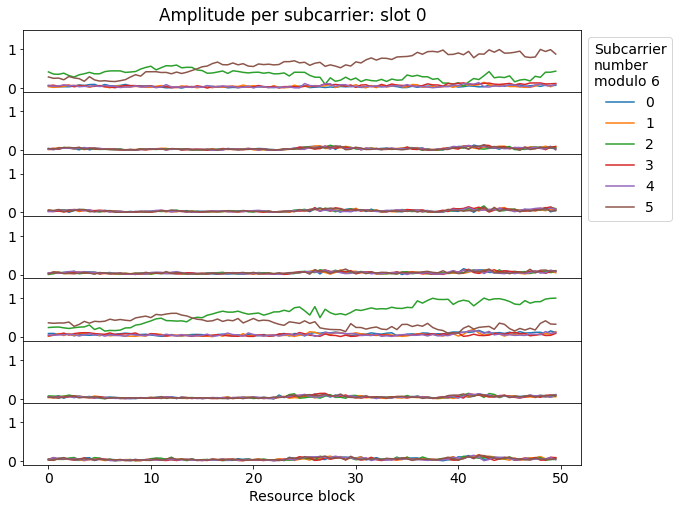

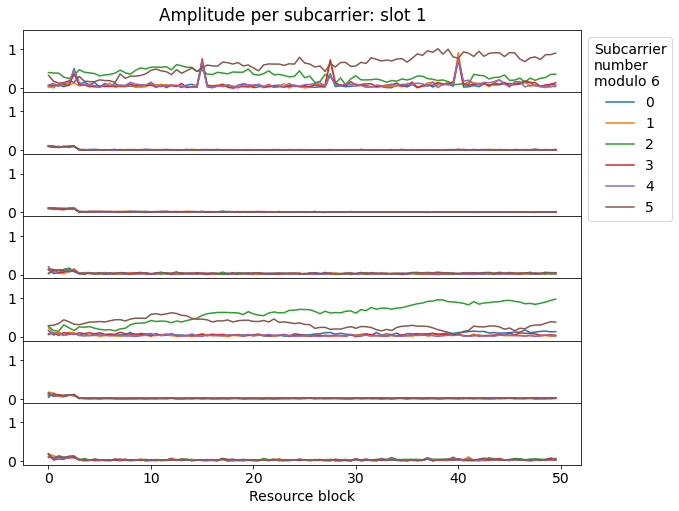

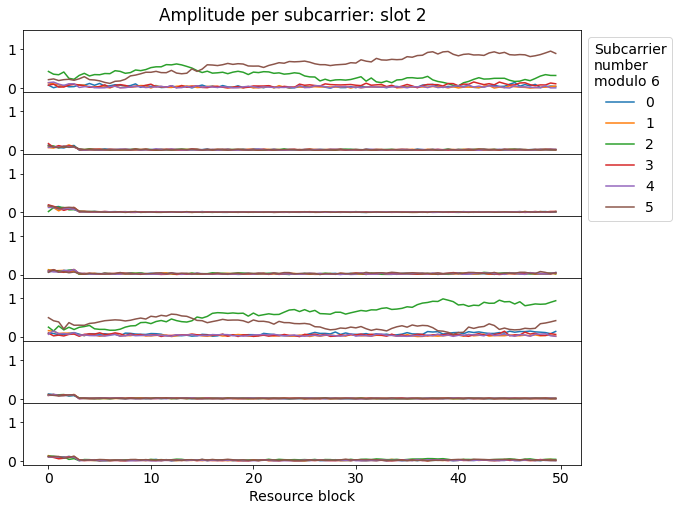

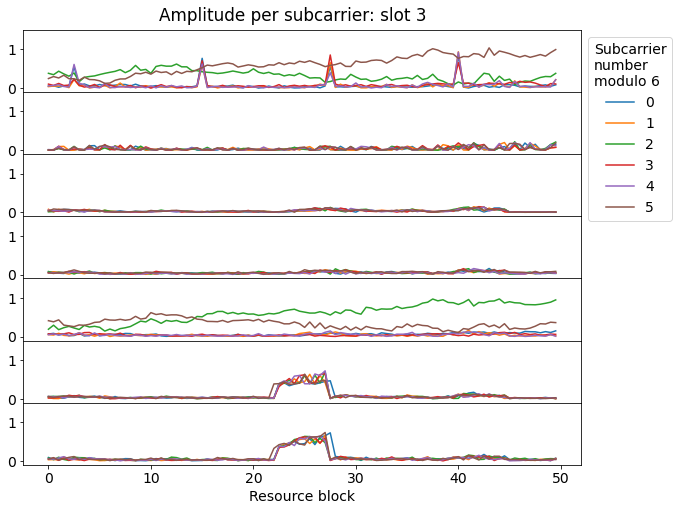

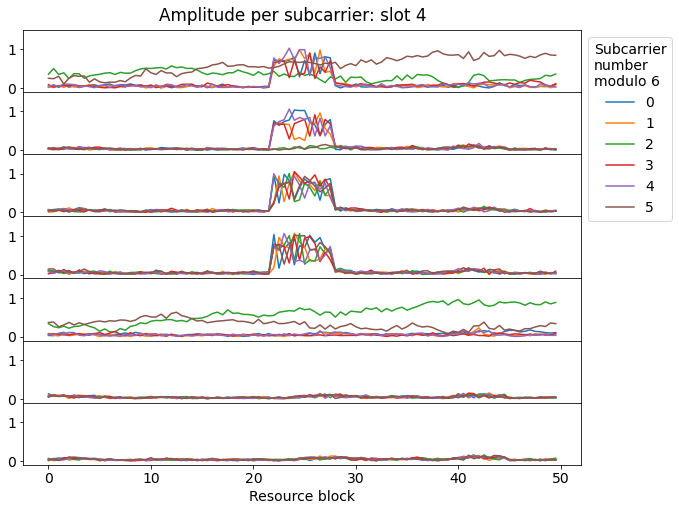

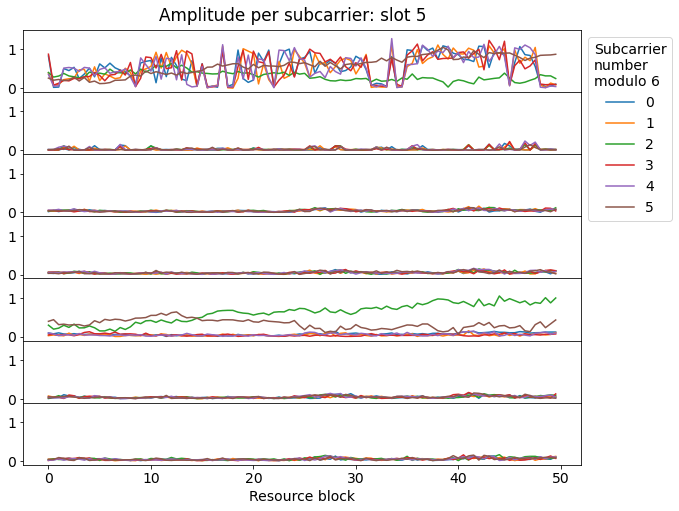

In [6]:
for slot in range(6):
    fig, axs = plt.subplots(7, 1, figsize=(10, 8), sharex=True, sharey=True)
    for j, ax in enumerate(axs):
        for k in range(6):
            n = np.arange(0, NRB, 0.5)
            ax.plot(n, np.abs(symbols[7 * slot + j, no_dc][k::6]),
                    label=f'{k}')
        ax.set_yticks([0, 1.0])
    plt.ylim((-0.1, 1.5))
    plt.xlabel('Resource block')
    plt.suptitle(f'Amplitude per subcarrier: slot {slot}', y=0.92)
    plt.legend(bbox_to_anchor=(1, 7), loc='upper left', title='Subcarrier\nnumber\nmodulo 6')
    plt.subplots_adjust(hspace=0)

In [7]:
# Psedurandom sequence following Section 7.2 in 3GPP TS 36.211
def c_seq(c_init, M_PN):
    x1 = 1
    x2 = c_init
    NC = 1600
    c = np.zeros(M_PN, 'uint8')
    # Drop the first NC terms
    for j in range(NC + M_PN):
        if j >= NC:
            c[j - NC] = (x1 ^ x2) & 1
        x1 = (((x1 ^ (x1 >> 3)) & 1) << 30) | (x1 >> 1)
        x2 = (((x2 ^ (x2 >> 1) ^ (x2 >> 2) ^ (x2 >> 3)) & 1) << 30) | (x2 >> 1)
    return c

# QPSK sequence for CRS
def r_seq(ns, l, pci=380):
    NCP = 1  # normal cyclic prefix
    NRBmaxDL = 110
    c_init_rs = 2**10 * (7 * (ns + 1) + l + 1) * (2 * pci + 1) + 2 * pci + NCP
    c = c_seq(c_init_rs, 4 * NRBmaxDL)
    cc = (1 - 2 * c.astype('float')) / np.sqrt(2)
    r = cc[::2] + 1j * cc[1::2]
    return r[NRBmaxDL-NRB:-(NRBmaxDL-NRB)]

In [8]:
# Wipe off QPSK sequence in CRS
# We also consider the CRS for cells in the same group, but they are too noisy
# to estimate a channel well.
ns0 = 17
r0_wipe = {}
r1_wipe = {}
for pci in [378, 379, 380]:
    r0w = np.empty((slots * 2, 2 * NRB), 'complex')
    r1w = np.empty_like(r0w)
    for j in range(2 *  slots):
        symidx = (j // 2) * 7 + 4 * (j % 2)
        nu = (pci + 3 * (j % 2)) % 6
        ns = (symidx // 7 + ns0) % 20
        r = r_seq(ns, symidx % 7, pci=pci)
        r0w[j] = symbols[symidx, no_dc][nu::6] * np.conjugate(r)
        r1w[j] = symbols[symidx, no_dc][(nu+3)%6::6] * np.conjugate(r)
    r0_wipe[pci] = r0w
    r1_wipe[pci] = r1w

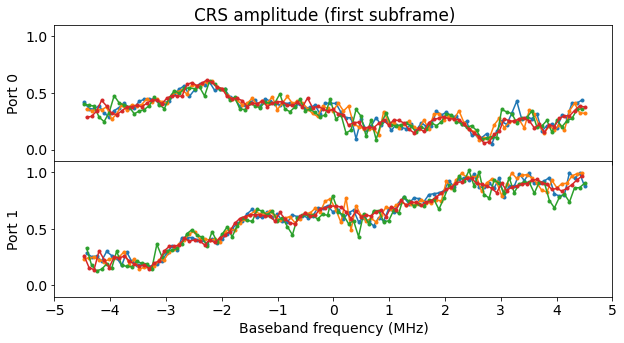

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for j in range(4):
    nu = (pci + (j % 2)*3) % 6
    f = freq_syms[no_dc][nu::6] * 1e-6
    axs[0].plot(f, np.abs(r0_wipe[380][j]), '.-')
    f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
    axs[1].plot(f, np.abs(r1_wipe[380][j]), '.-')
plt.ylim((-0.1, 1.1))
plt.subplots_adjust(hspace=0)
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('CRS amplitude (first subframe)', y=0.93);

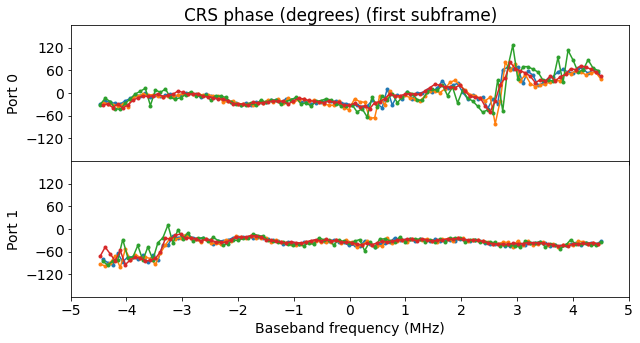

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for j in range(4):
    nu = (pci + (j % 2)*3) % 6
    f = freq_syms[no_dc][nu::6] * 1e-6
    axs[0].plot(f, np.rad2deg(np.angle(r0_wipe[380][j])), '.-')
    f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
    axs[1].plot(f, np.rad2deg(np.angle(r1_wipe[380][j])), '.-')
plt.ylim((-180, 180))
plt.subplots_adjust(hspace=0)
plt.yticks(np.arange(-180 + 60, 180, 60))
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('CRS phase (degrees) (first subframe)', y=0.93);

## Channel estimation

In [11]:
# Calculation of cubic spline in terms of it coefficients.
# This is used to fit a cubic spline to the channel.
def cubic_spline(coeffs):
    coeffs = coeffs.reshape(-1, 2)
    values = np.empty(NRB * 12, 'complex')
    values = values.reshape(coeffs.shape[0] - 1, -1)
    for j in range(values.shape[0]):
        # p(x) = ax^3 + bx^2 + cx + d
        # a = 2p(0) + p'(0) - 2p(1) + p'(1)
        # b = -3p(0) - 2p'(0) + 3p(1) - p'(1)
        # c = p'(0)
        # d = p(0)
        cf = coeffs[j:j+2].ravel()
        p = np.array([2*cf[0] + cf[1] - 2*cf[2] + cf[3],
                      -3*cf[0] - 2*cf[1] + 3*cf[2] - cf[3],
                      cf[1],
                      cf[0]])
        t = (np.arange(values.shape[1]) + 1) / (values.shape[1] + 1)
        values[j] = np.polyval(p, t)
    # Add central subcarrier (copying the values of the two neighbouring subcarriers)
    values = values.reshape(2, -1)
    return np.concatenate((values[0], [values[0, -1]], values[1]))

ncoeffs = 22
# Matrix for solving the linear least squares fit of the cubic spline
A_cubic_spline = np.array([cubic_spline(np.eye(1, ncoeffs, j)) for j in range(ncoeffs)]).T

In [12]:
# Least squares fit of the cubic spline to the CRS complex amplitudes
r0_fit = {}
r1_fit = {}
for pci in [378, 380]:
    r0f = np.empty((slots * 2, ncoeffs), 'complex')
    r1f = np.empty_like(r0f)
    for j in range(slots * 2):
        nu = pci % 6
        r0f[j] = np.linalg.lstsq(A_cubic_spline[no_dc][nu::6],
                                 r0_wipe[pci][j], rcond=None)[0]
        r1f[j] = np.linalg.lstsq(A_cubic_spline[no_dc][(nu+3)%6::6],
                                 r1_wipe[pci][j], rcond=None)[0]
    r0_fit[pci] = r0f
    r1_fit[pci] = r1f

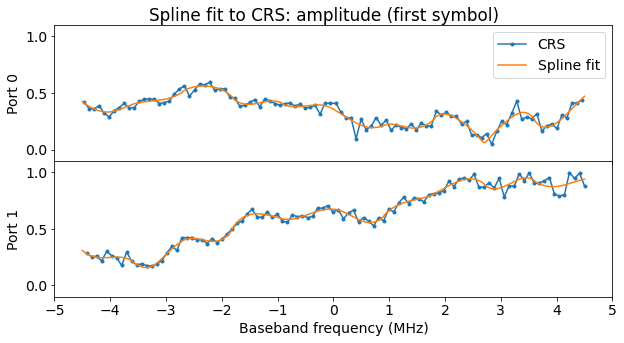

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
nu = pci % 6
f = freq_syms[no_dc][nu::6] * 1e-6
axs[0].plot(f, np.abs(r0_wipe[380][0]), '.-',
            label='CRS')
axs[0].plot(freq_syms * 1e-6, np.abs(cubic_spline(r0_fit[380][0])),
            label='Spline fit')
axs[0].legend()
f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
axs[1].plot(f, np.abs(r1_wipe[380][0]), '.-')
axs[1].plot(freq_syms * 1e-6, np.abs(cubic_spline(r1_fit[380][0])))
plt.ylim((-0.1, 1.1))
plt.subplots_adjust(hspace=0)
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('Spline fit to CRS: amplitude (first symbol)', y=0.93);

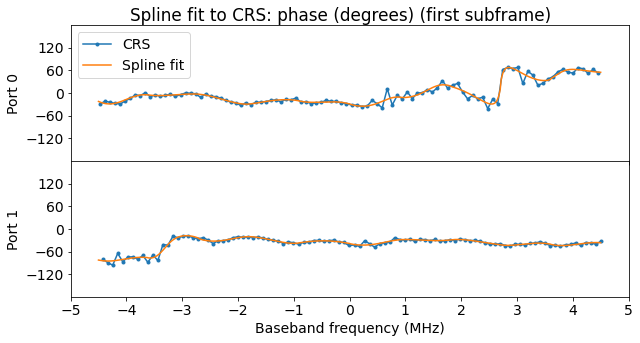

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
nu = pci % 6
f = freq_syms[no_dc][nu::6] * 1e-6
axs[0].plot(f, np.rad2deg(np.angle(r0_wipe[380][0])), '.-',
            label='CRS')
axs[0].plot(freq_syms * 1e-6, np.rad2deg(np.angle(cubic_spline(r0_fit[380][0]))),
            label='Spline fit')
axs[0].legend()
f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
axs[1].plot(f, np.rad2deg(np.angle(r1_wipe[380][0])), '.-')
axs[1].plot(freq_syms * 1e-6, np.rad2deg(np.angle(cubic_spline(r1_fit[380][0]))))
plt.ylim((-180, 180))
plt.subplots_adjust(hspace=0)
plt.yticks(np.arange(-180 + 60, 180, 60))
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('Spline fit to CRS: phase (degrees) (first subframe)', y=0.93);

In [15]:
# Calculation of channel by linear interpolation of cubic splines fitted to adjacent CRS
def channel(nsymbol, pci=380):
    nslot = nsymbol // 7
    left, adv, dist = (
        (2 * nslot, nsymbol - 7 * nslot, 4)
        if nsymbol % 7 < 4
        else (2 * nslot + 1, nsymbol - 7 * nslot - 4, 3))
    r0 = r0_fit[pci][left] * (1-adv/dist) + r0_fit[pci][left+1] * adv/dist
    r1 = r1_fit[pci][left] * (1-adv/dist) + r1_fit[pci][left+1] * adv/dist
    return (cubic_spline(r0), cubic_spline(r1))

# Removes the resource elements corresponding to CRS in one OFDM symbol
def remove_ref_signals(nsymbol, syms, pci=380, pbch=False):
    extra = [1] if pbch else []
    if nsymbol % 7 not in [0, 4] + extra:
        return syms
    sel = [j for j in range(6) if j not in [pci % 6, (pci + 3) % 6]]
    return syms.reshape(-1, 6)[:, sel].ravel()

# Extracts only the resource elements corresponding to CRS in one OFDM symbol
def ref_signals(nsymbol, syms, port, pci=380):
    if nsymbol % 7 not in [0, 4]:
        return np.array([])
    nu = (pci + (port * 3) + (nsymbol % 7 == 4) * 3) % 6
    return syms.reshape(-1, 6)[:, nu::6].ravel()

# Transmit diversity equalization
def diversity(syms, r0, r1):
    y = np.empty_like(syms)
    y[::2] = ((np.conjugate(r0[::2]) * syms[::2] + r1[1::2] * np.conjugate(syms[1::2])) 
              / (np.abs(r0[::2])**2 + np.abs(r1[1::2])**2))
    y[1::2] = ((-r1[::2] * np.conjugate(syms[::2]) + np.conjugate(r0[1::2]) * syms[1::2])
               / (np.abs(r0[1::2])**2 + np.abs(r1[::2])**2))
    return y

## Transmit diversity equalization

In [16]:
def diversity_plot(nsyms, subcarrier_sel, transmit_port='diversity', pbch=False):
    sel = no_dc[subcarrier_sel]
    nrows = (nsyms.stop - 1) // 7 - nsyms.start // 7 + 1
    width = 10
    height = width * nrows / 7
    fig, axs = plt.subplots(nrows, 7, figsize=(width, height), facecolor='w', sharex=True, sharey=True)
    axs = axs.reshape(nrows, 7)
    for nsym in nsyms:
        row = nsym // 7 - nsyms.start // 7
        col = nsym % 7
        ax = axs[row, col]
    
        r0, r1 = channel(nsym)
        if transmit_port == 'diversity':
            x = diversity(remove_ref_signals(nsym, symbols[nsym, sel], pbch=pbch),
                          remove_ref_signals(nsym, r0[sel], pbch=pbch),
                          remove_ref_signals(nsym, r1[sel], pbch=pbch))
        elif transmit_port == 0:
            x = (remove_ref_signals(nsym, symbols[nsym, sel], pbch=pbch)
                 / remove_ref_signals(nsym, r0[sel], pbch=pbch))
        else:
            x = (remove_ref_signals(nsym, symbols[nsym, sel])
                 / remove_ref_signals(nsym, r1[sel], pbch=pbch))
        ax.plot(x.real, x.imag, '.')
    for row in range(nrows):
        for col in range(7):
            ax = axs[row, col]
            nsym = nsyms.start//7 * 7 + row * 7 + col
            r0, r1 = channel(nsym)
            ax.plot([], [], '.', label='Non-reference', color='C0')
            for port in range(2):
                ref = r0 if port == 0 else r1
                r = ref_signals(nsym, symbols[nsym, sel] / ref[sel], port)
                if r.size:
                    ax.plot(r.real, r.imag, '.', label=f'R{port}', color=f'C{port+1}')
                  
            ax.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                     np.array([1, -1, 1, -1])/np.sqrt(2), '.',
                     color='red', markersize=3)

            ax.set_xlim((-2, 2))
            ax.set_ylim((-2, 2))
            ax.set_xticks([])
            ax.set_yticks([])
    for row in range(nrows):
        axs[row, 0].set_ylabel(f'Slot {row + nsyms.start // 7}')
    for col in range(7):
        axs[-1, col].set_xlabel(f'Symbol {col}', rotation=45)
        
    fig.subplots_adjust(hspace=0, wspace=0)
    axs[0, 0].legend(bbox_to_anchor=(7, 1), loc='upper left')
    if transmit_port == 'diversity':
        using = 'transmit diversity'
    else:
        using = f'antenna port {transmit_port}'
    rbs = np.arange(NRB*12)[subcarrier_sel]
    rb0 = rbs[0] // 12
    rb1 = rbs[-1] // 12
    fig.suptitle(f'Symbols equalized using {using} (RBs {rb0}-{rb1})', y=1.05);

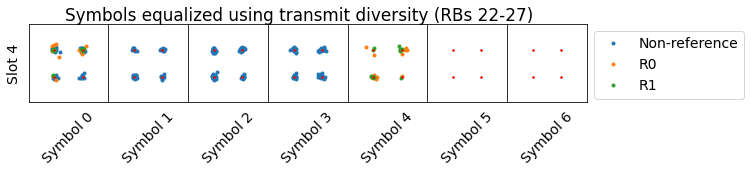

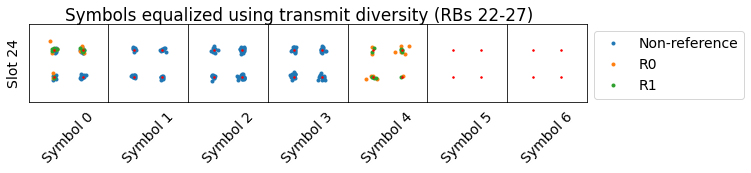

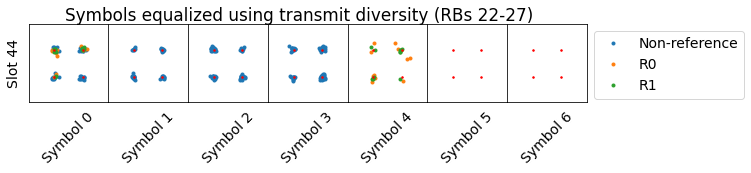

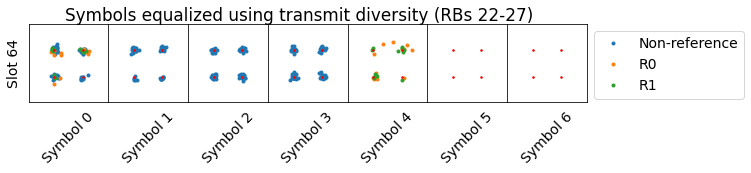

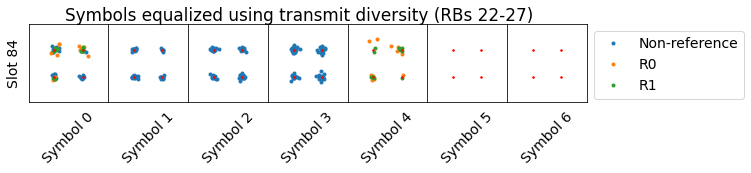

In [17]:
# Plots of the demodulation of a few PBCH transmissions
for start in range(28, nsymbols, 140)[:5]:
    diversity_plot(range(start, start+4), slice(22*12, 28*12), pbch=True)

## PBCH

In [18]:
# Demodulate all the PBCH transmissions
pbch = [diversity(
            remove_ref_signals(k, symbols[j+k, no_dc][22*12:28*12], pbch=True),
            remove_ref_signals(k, channel(j+k)[0][22*12:28*12], pbch=True),
            remove_ref_signals(k, channel(j+k)[1][22*12:28*12], pbch=True))
        for j in range(4*7, symbols.shape[0], 140) for k in range(4)]

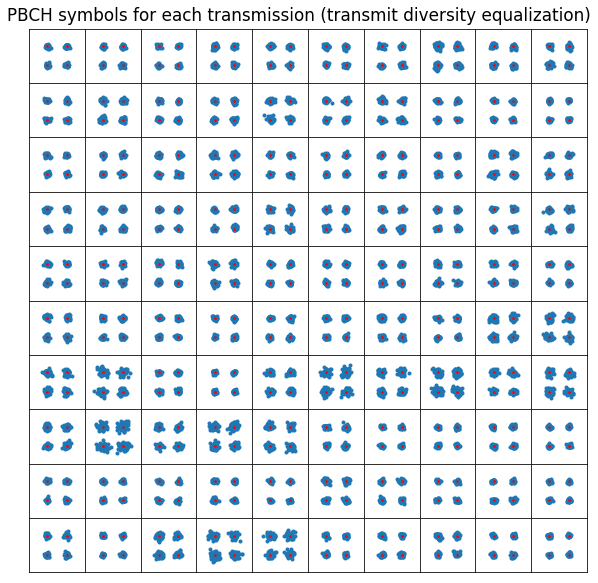

In [19]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = np.concatenate(pbch[4*idx:4*(idx+1)])
        ax.plot(syms.real, syms.imag, '.')
        ax.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                np.array([1, -1, 1, -1])/np.sqrt(2), '.',
                color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PBCH symbols for each transmission (transmit diversity equalization)', y=0.91);

## PDSCH equalization

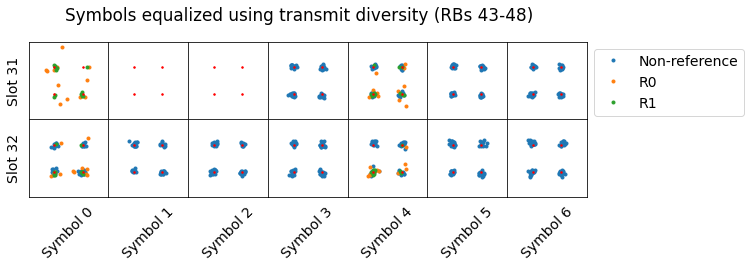

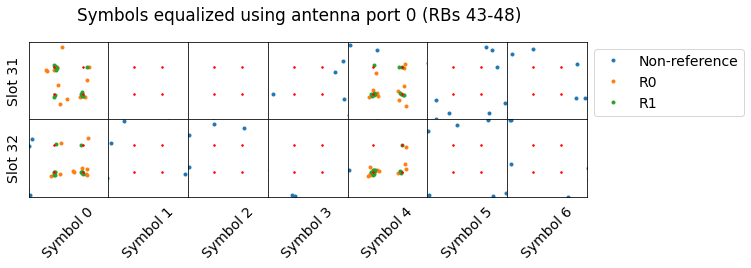

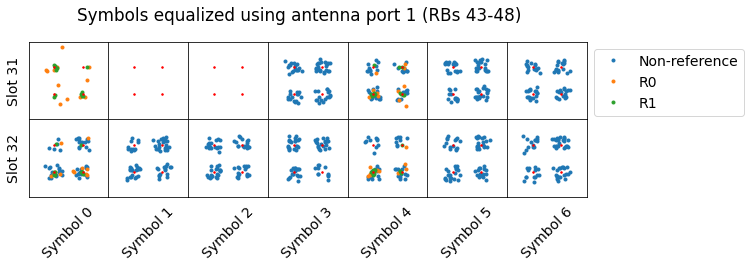

In [20]:
# Comparison of equalization of a PDSCH transmission using transmit diversity and only one antenna port
diversity_plot(range(220, 231), slice(-7*12, -12))
diversity_plot(range(220, 231), slice(-7*12, -12), transmit_port=0)
diversity_plot(range(220, 231), slice(-7*12, -12), transmit_port=1)

## PCFICH

In [21]:
# PCFICH demodulation
symidx0 = 7
npcfich = (nsymbols - symidx0)//14
pcfich = np.empty((npcfich, 16), 'complex')
symidx_pcfich = np.arange(symidx0, nsymbols, 14)
ns_pcfich = (symidx_pcfich // 7 + ns0) % 20
kbar = 6 * (pci % (2 * NRB))
for j, symidx in enumerate(symidx_pcfich):
    r0, r1 = channel(symidx)
    pcfich[j] = np.concatenate([
        diversity(
            remove_ref_signals(0, symbols[symidx, no_dc][(kbar+offset)%(12*NRB):][:6], pbch=True),
            remove_ref_signals(0, r0[no_dc][(kbar+offset)%(12*NRB):][:6], pbch=True),
            remove_ref_signals(0, r1[no_dc][(kbar+offset)%(12*NRB):][:6], pbch=True))
        for offset in [0, 6 * (NRB//2), 6 * (2*NRB//2), 6 * (3*NRB//2)]])

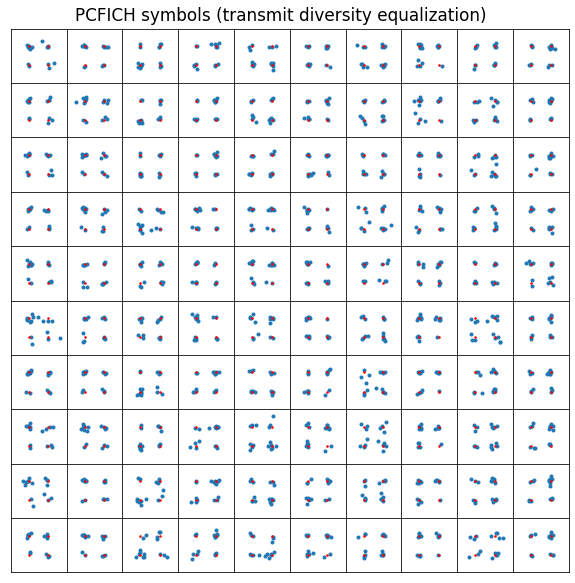

In [22]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = pcfich[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                np.array([1, -1, 1, -1])/np.sqrt(2), '.',
                color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PCFICH symbols (transmit diversity equalization)', y=0.91);

In [23]:
# PCFICH decoding using hard decision
pcfich_bits = 1 * (pcfich.astype('complex64').view('float32') < 0)
scramble = np.array([c_seq((ns//2 + 1) * (2 * pci + 1) * 2**9 + pci, 32)
                     for ns in ns_pcfich])
pcfich_descramble = pcfich_bits ^ scramble

In [24]:
# Table 5.3.4-1: CFI code words from 3GPP 36.212
cfi_codings = np.array(
    [[0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1],
     [1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0],
     [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1]])

In [25]:
pcfich_bit_errors = np.sum(pcfich_descramble[:, np.newaxis, :] ^ cfi_codings, axis=-1)
pcfich_values = 1 + np.argmin(pcfich_bit_errors, axis=1)
pcfich_bit_errors = np.min(pcfich_bit_errors, axis=1)

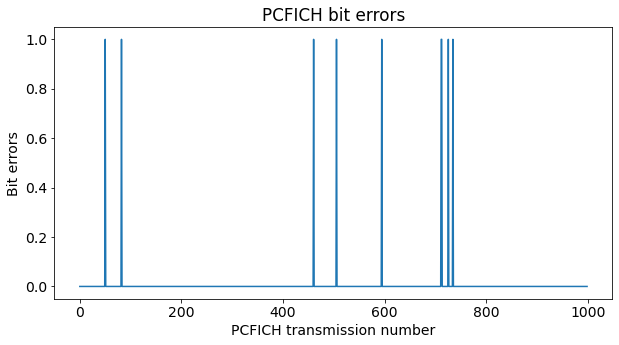

In [26]:
plt.plot(pcfich_bit_errors)
plt.title('PCFICH bit errors')
plt.ylabel('Bit errors')
plt.xlabel('PCFICH transmission number');

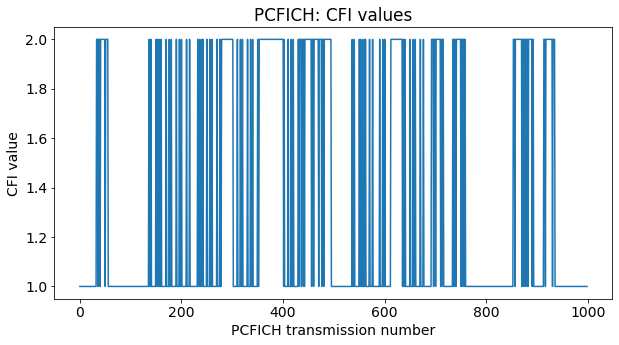

In [27]:
plt.plot(pcfich_values)
plt.title('PCFICH: CFI values')
plt.ylabel('CFI value')
plt.xlabel('PCFICH transmission number');

## PDSCH

In [28]:
# Compute PDSCH power in order to power-detect PDSCH allocations

rb_power = (np.abs(symbols[:, no_dc])**2)
# Blank PCFICH
kbar = 6 * (pci % (2 * NRB))
for offset in [0, 6 * (NRB//2), 6 * (2*NRB//2), 6 * (3*NRB//2)]:
    rb_power[7::14, (kbar+offset)%(NRB*12):][:, :6] = np.nan
rb_power = rb_power.reshape((-1, NRB, 12))
# Blank CRS
rb_power[::7, :, (pci%3)::3] = np.nan
rb_power[4::7, :, (pci%3)::3] = np.nan
# Blank PSS and SSS
rb_power[3*7+5::70, NRB//2-3:NRB//2+3] = 0
rb_power[3*7+6::70, NRB//2-3:NRB//2+3] = 0

# Blank PBCH
for j in range(4):
    rb_power[4*7+j::140, NRB//2-3:NRB//2+3] = 0
rb_power = np.nanmean(rb_power, axis=-1)

pdsch_power = rb_power.copy()
pdsch_power = pdsch_power[7:]  # Align to start of subframe
pdsch_power = pdsch_power.reshape(-1, 14, NRB)
# Blank control symbols according to CFI
pdsch_power[:, ::7] = np.nan
pdsch_power[pcfich_values == 2, 1::7] = np.nan
pdsch_power = np.nanmean(pdsch_power, axis=1)

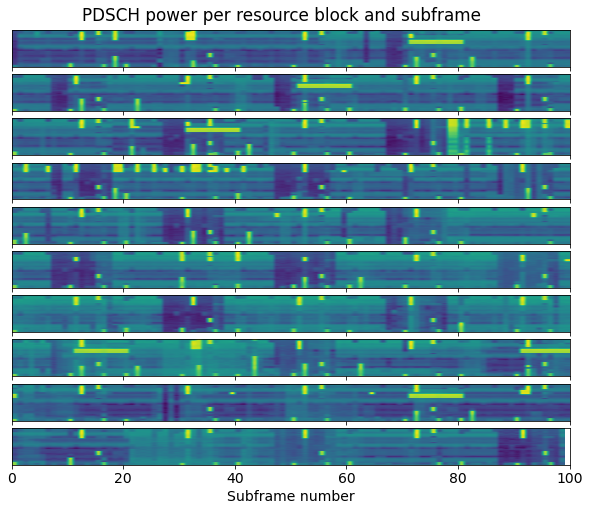

In [29]:
per_row = 100
fig, axs = plt.subplots(int(np.ceil(pdsch_power.shape[0]/per_row)), 1, 
                        figsize=(10, 8),
                        sharex=True, sharey=True)
for j, ax in enumerate(axs):
    a = pdsch_power[j*per_row:(j+1)*per_row, ::-1]
    ax.imshow(10*np.log10(a.T),
              aspect='auto', interpolation=None,
              extent=[0, a.shape[0], 0, NRB],
              vmin=10*np.log10(np.min(pdsch_power)),
              vmax=10*np.log10(np.max(pdsch_power)))
    ax.set_xlim((0, per_row))
    ax.set_yticks([])
axs[-1].set_xlabel('Subframe number');
plt.suptitle('PDSCH power per resource block and subframe', y=0.92);

In [30]:
cutoff = 0.03
pdsch_detect = pdsch_power >= cutoff

In [31]:
# Cluster PDSCH allocations in adjacent resource blocks in the same subframe

def cluster(x):
    clusters = []
    start = None
    for j, a in enumerate(x):
        if not a:
            if start is not None:
                clusters.append((start, j))
                start = None
        elif start is None:
            start = j
    if start is not None:
        clusters.append((start, j+1))
    return clusters

pdsch_allocations = []
for j, x in enumerate(pdsch_detect):
    for y in cluster(x):
        pdsch_allocations.append((j, y))

/tmp/ipykernel_1149/2723175641.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows, 7, figsize=(width, height), facecolor='w', sharex=True, sharey=True)


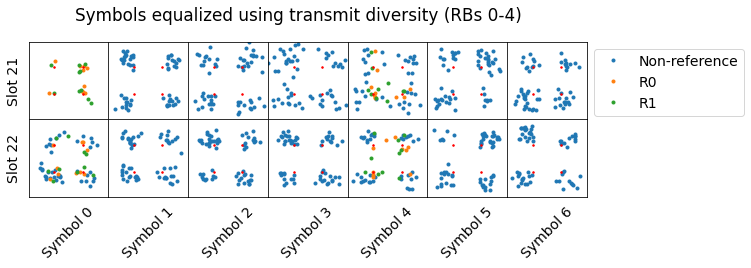

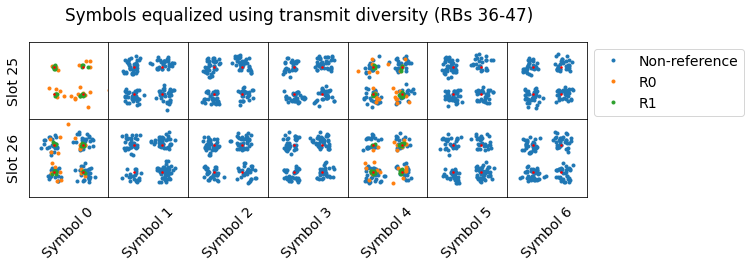

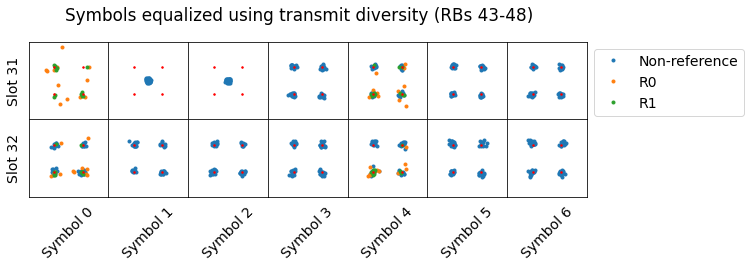

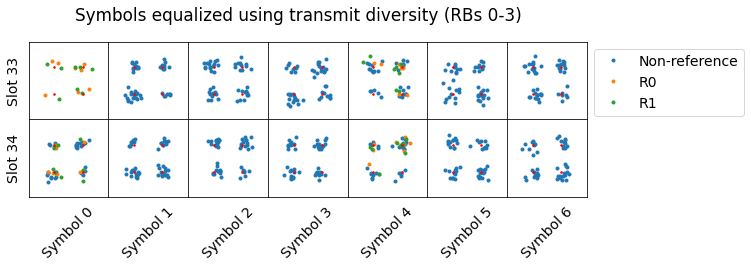

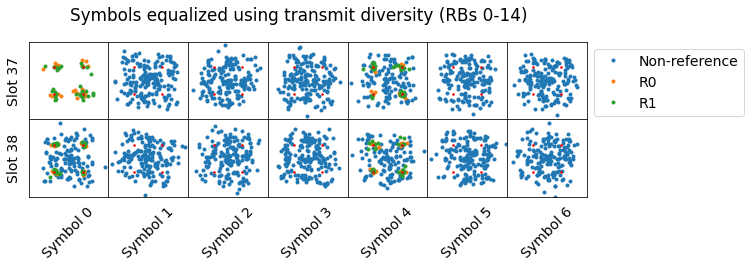

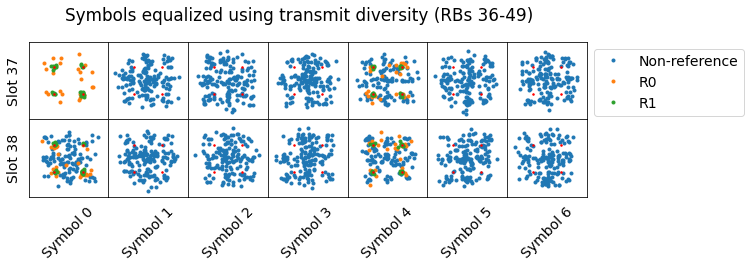

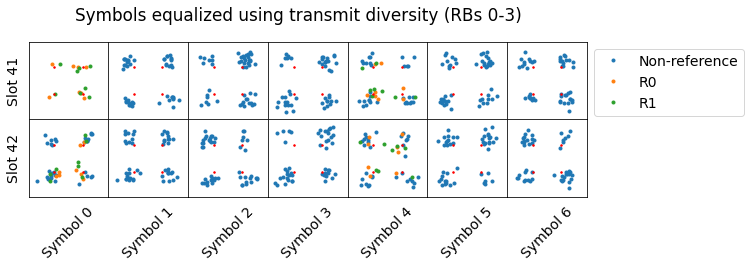

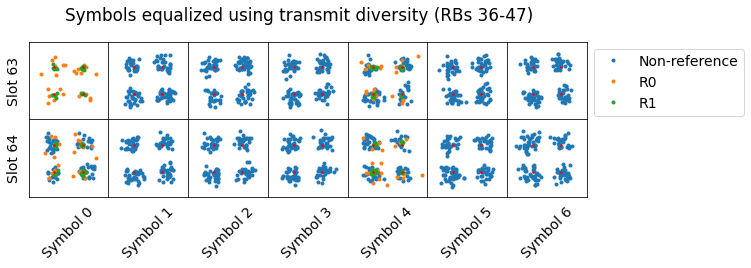

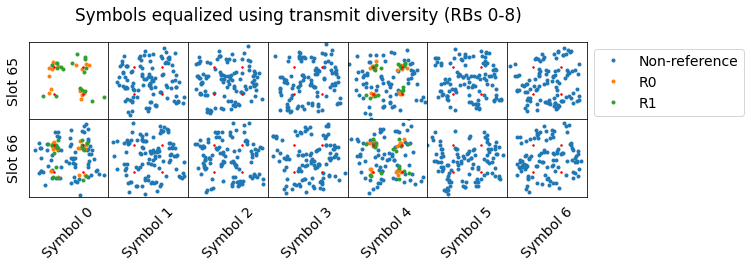

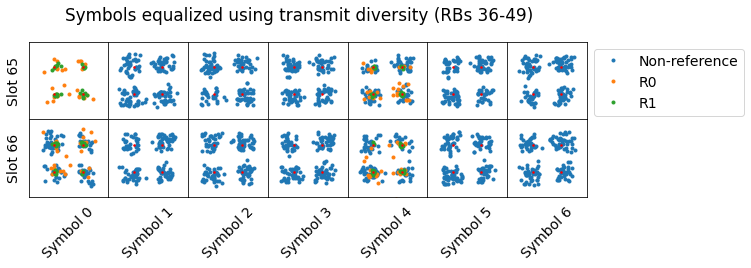

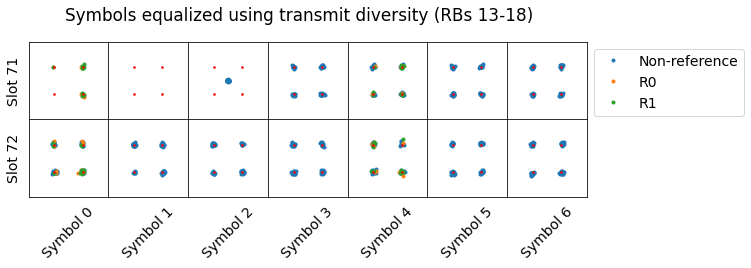

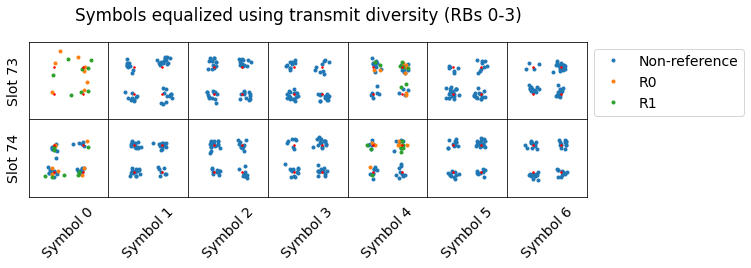

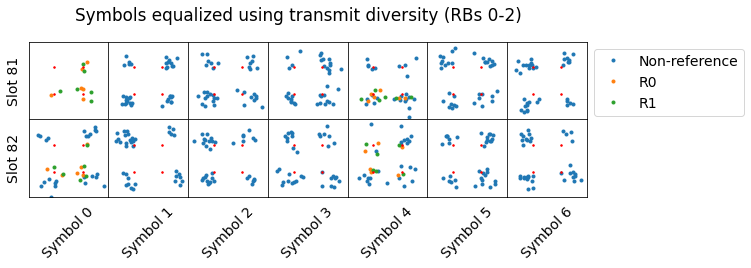

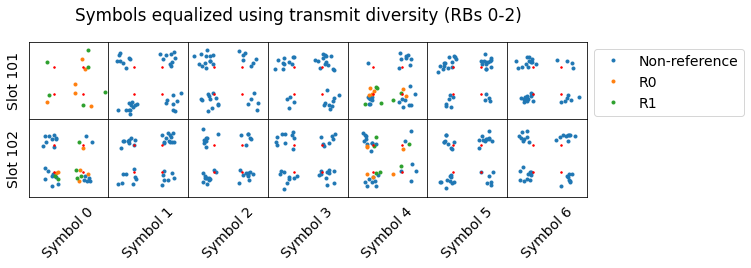

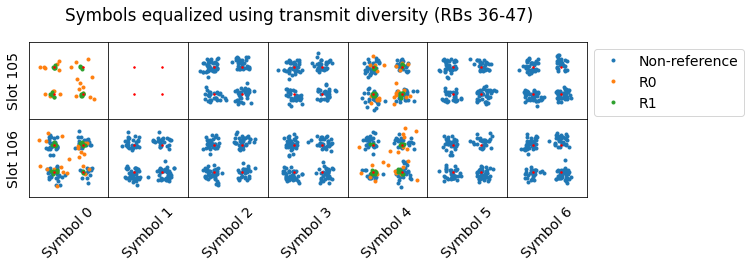

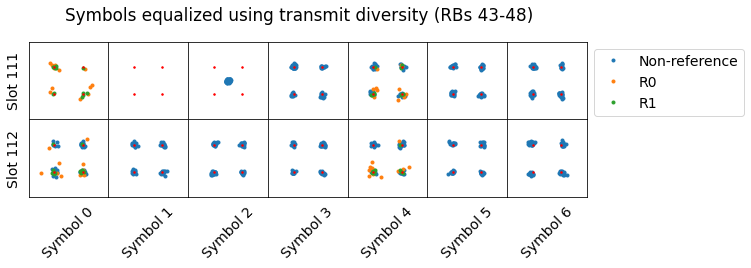

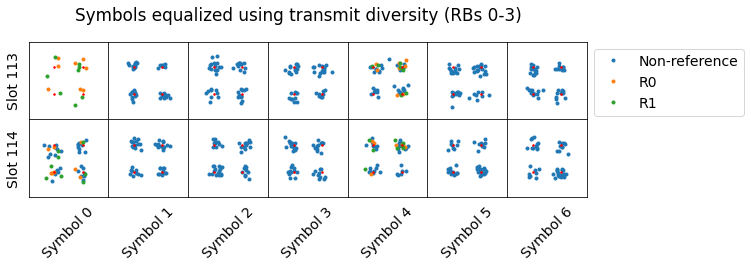

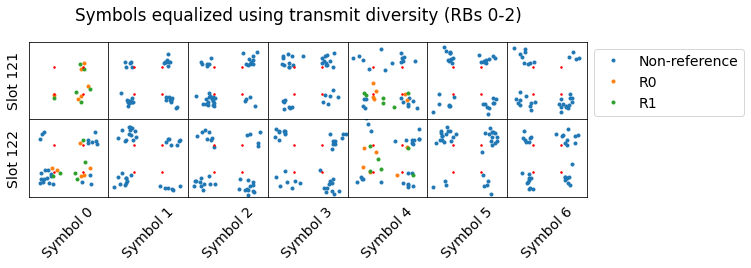

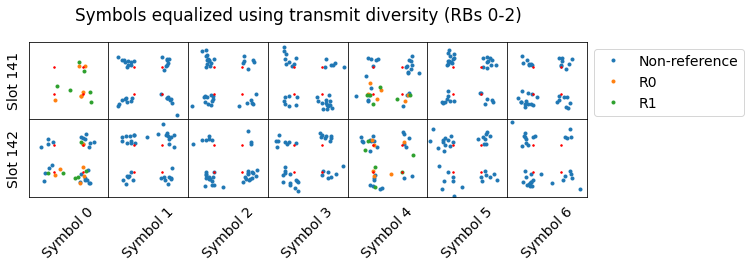

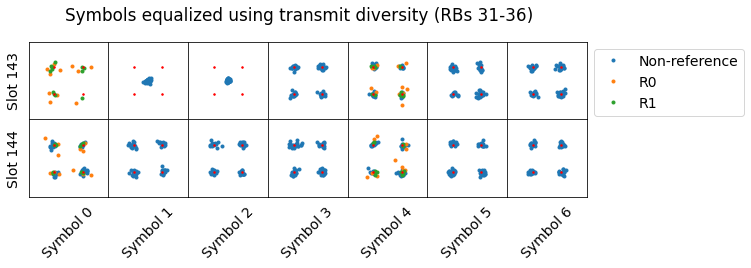

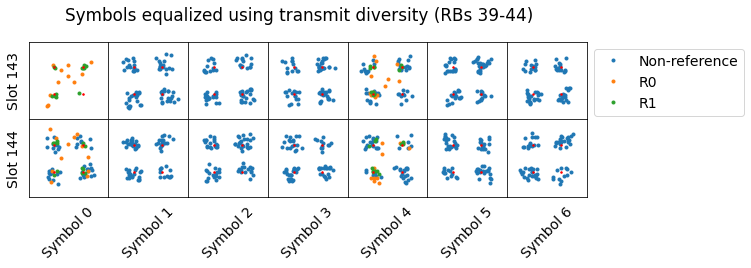

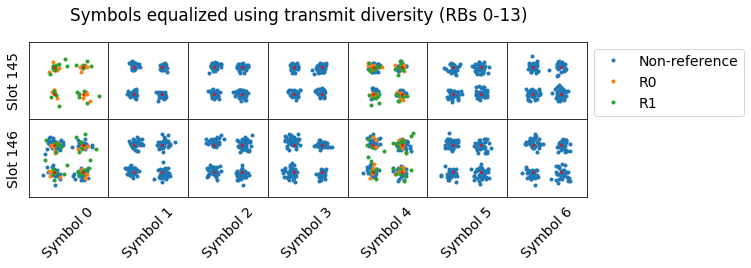

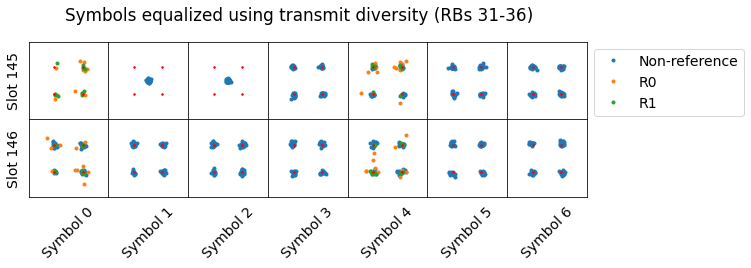

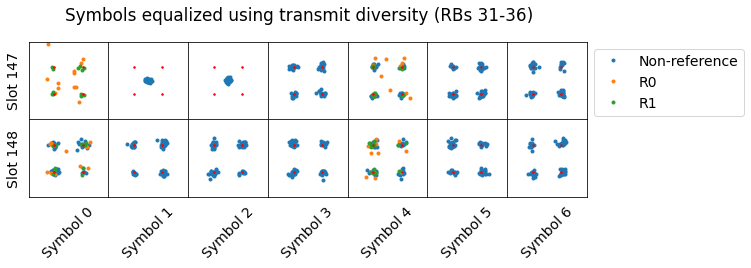

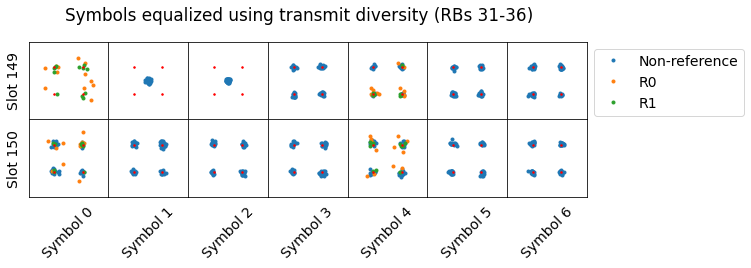

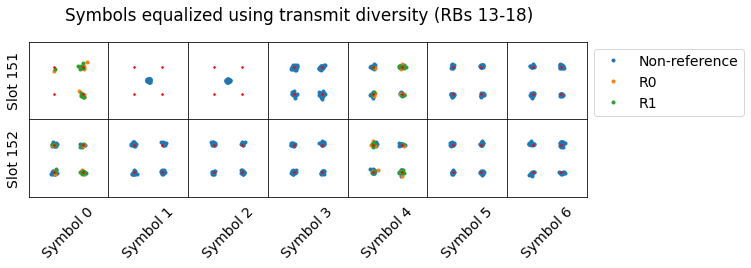

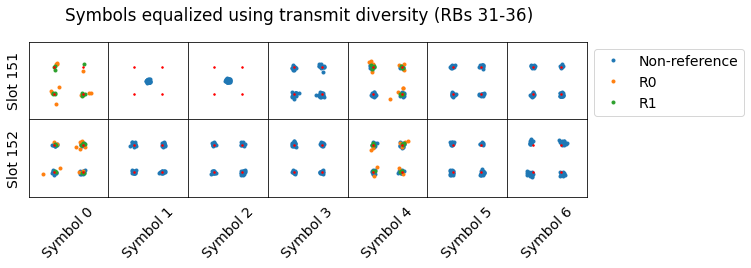

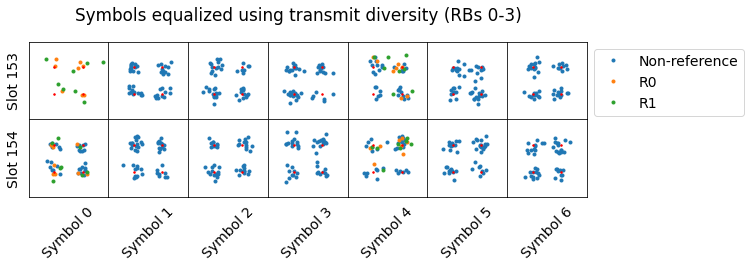

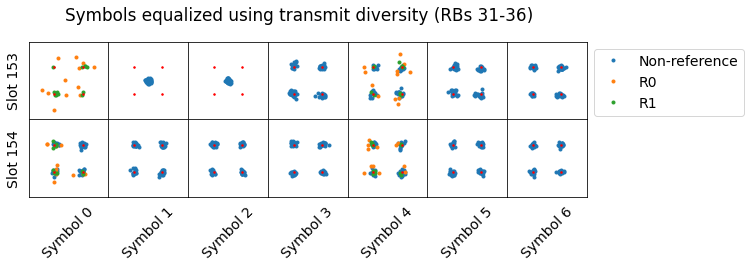

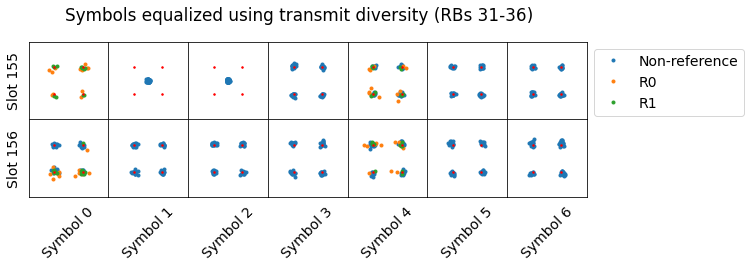

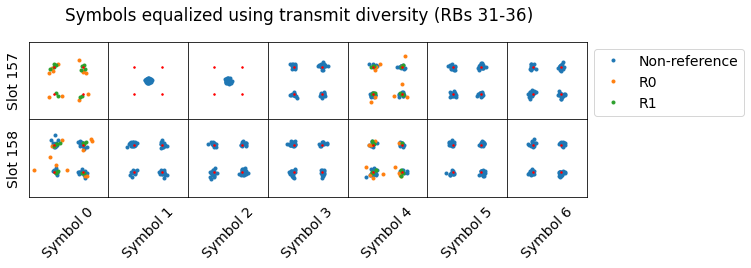

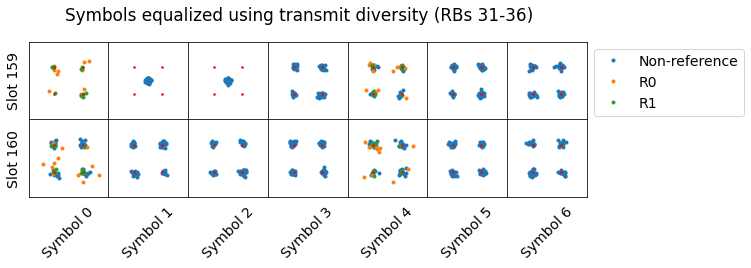

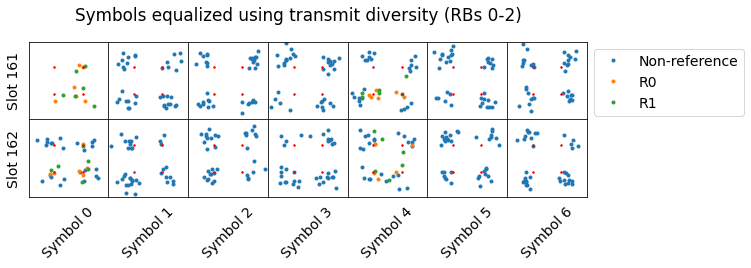

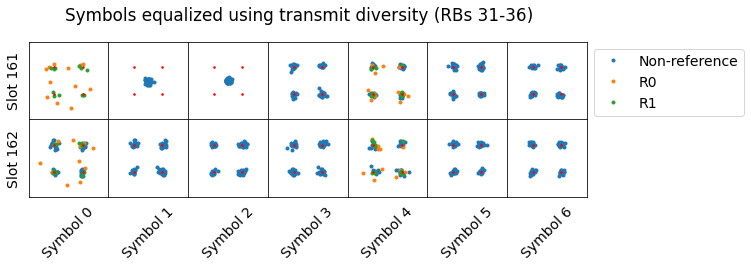

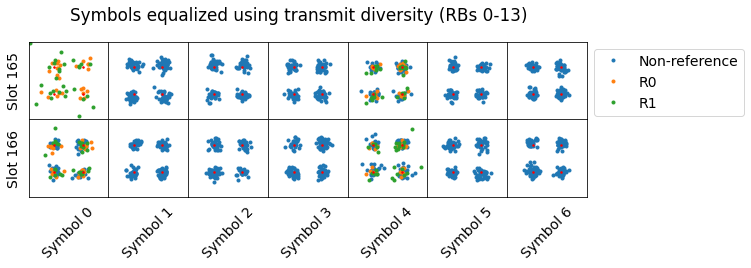

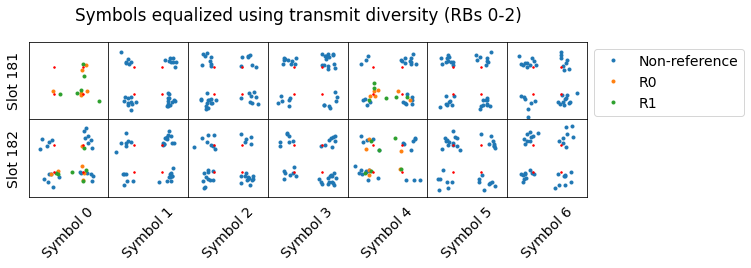

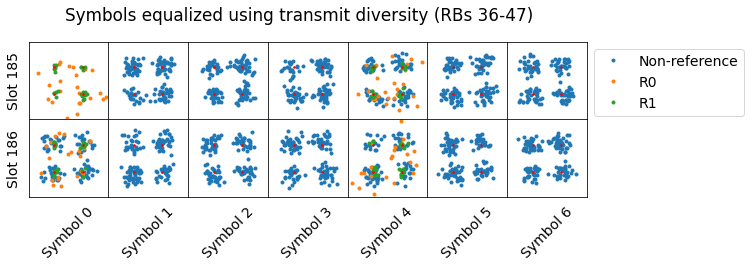

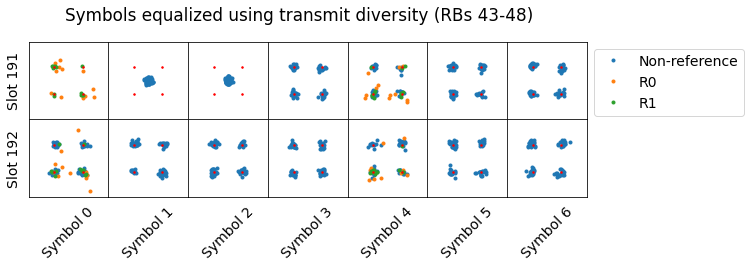

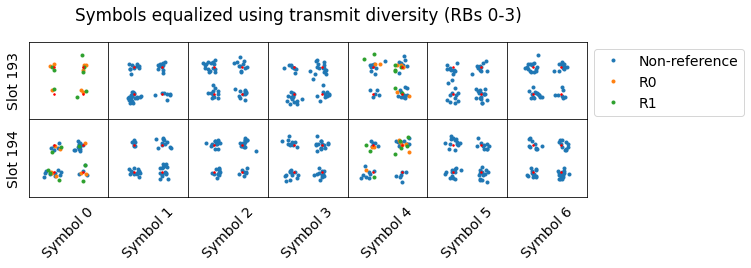

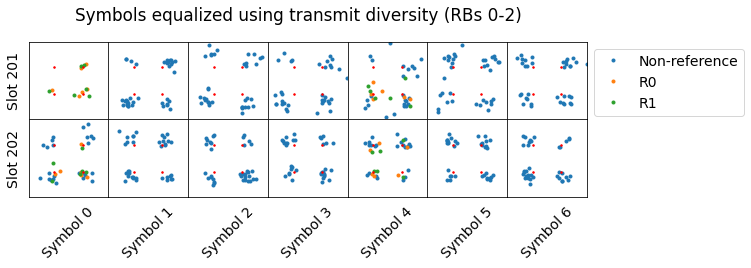

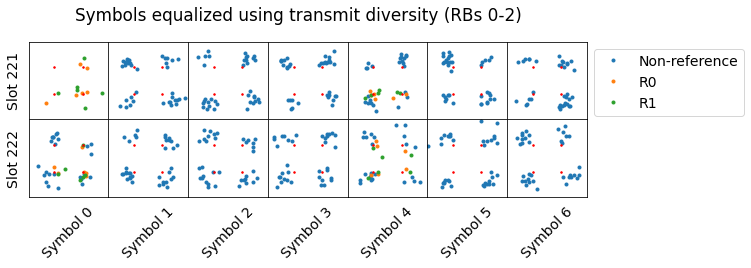

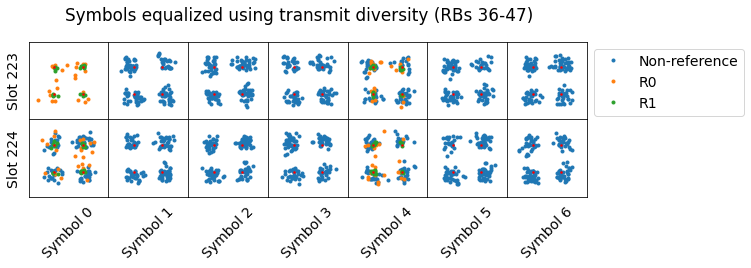

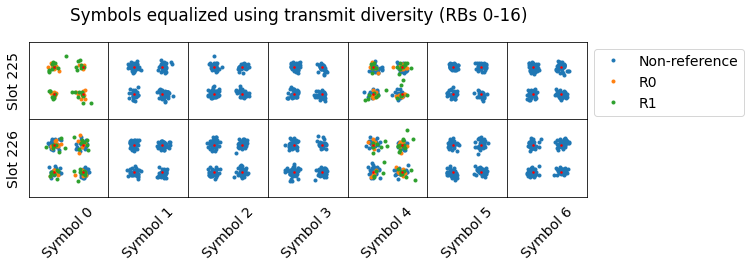

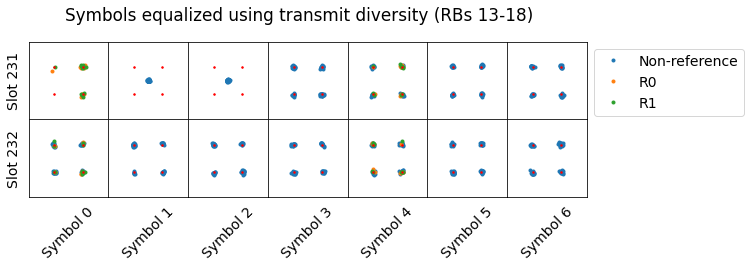

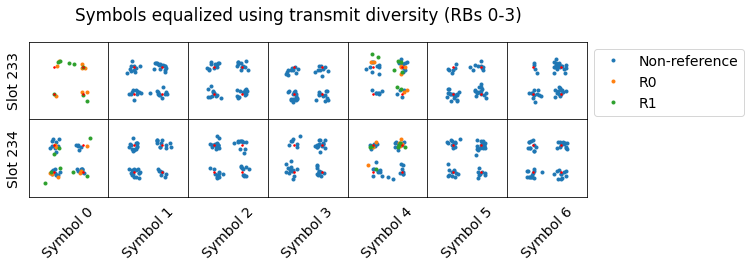

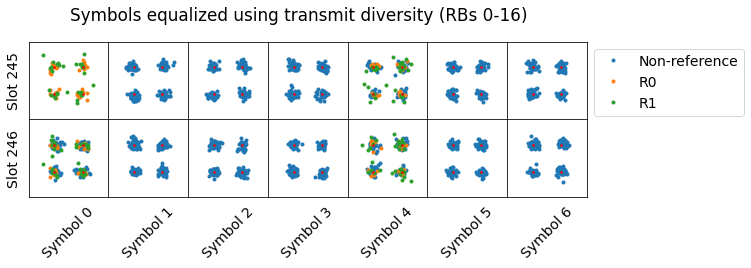

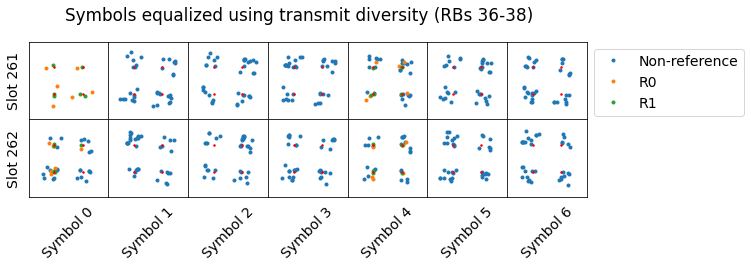

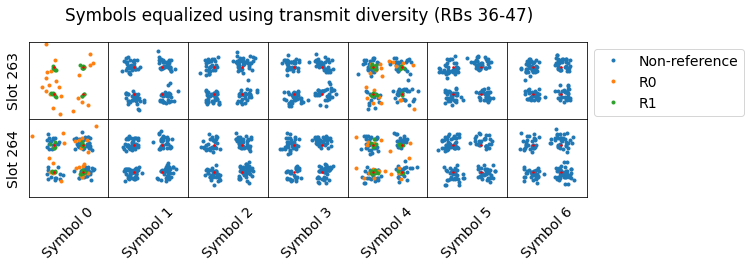

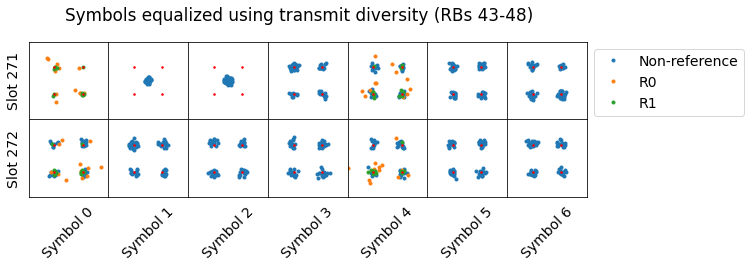

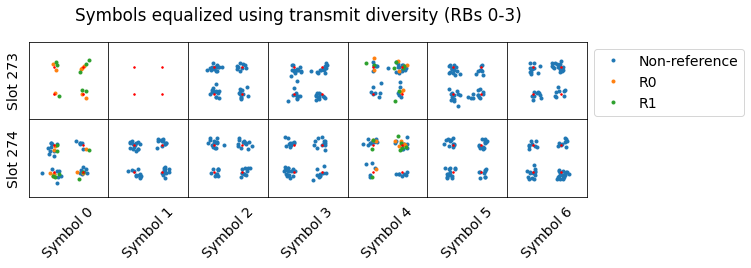

In [32]:
# Plot the demodulation of the first 50 PDSCH transmissions
for alloc in pdsch_allocations[:50]:
    sym0 = 7 + alloc[0] * 14 + pcfich_values[alloc[0]]
    sym_end = 7 + alloc[0] * 14 + 14 
    syms = range(sym0, sym_end)
    subcarriers = slice(alloc[1][0]*12, alloc[1][1]*12)
    diversity_plot(syms, subcarriers)

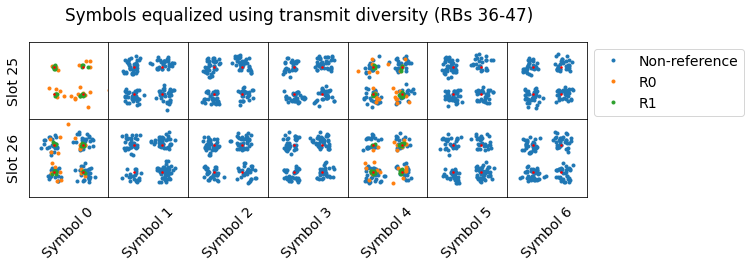

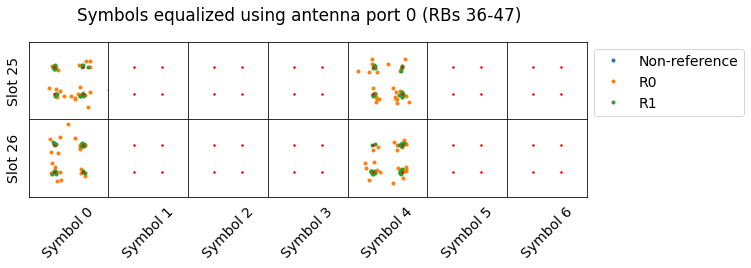

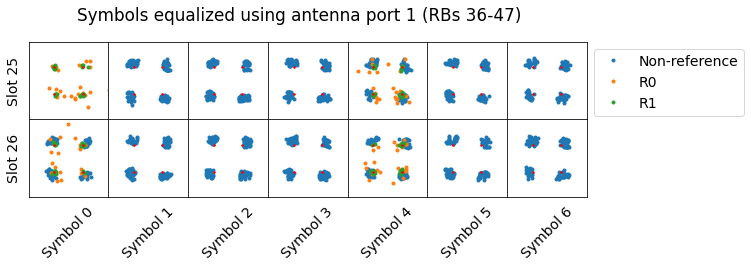

In [33]:
# Comparison of different equalizations for some transmissions
diversity_plot(range(176, 189), slice(-14*12, -2*12))
diversity_plot(range(176, 189), slice(-14*12, -2*12), transmit_port=0)
diversity_plot(range(176, 189), slice(-14*12, -2*12), transmit_port=1)

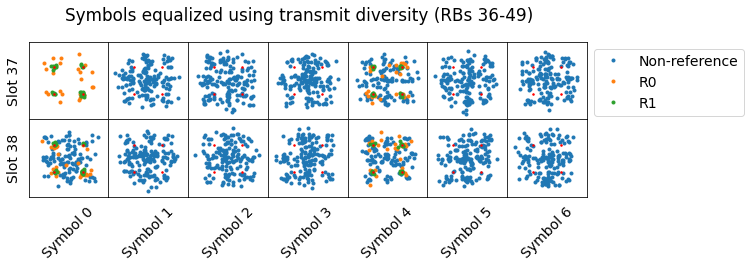

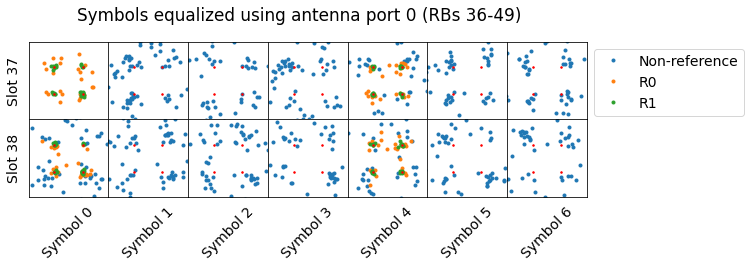

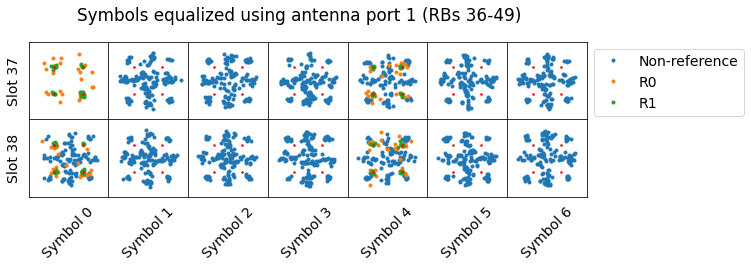

In [34]:
diversity_plot(range(260, 273), slice(-14*12, None))
diversity_plot(range(260, 273), slice(-14*12, None), transmit_port=0)
diversity_plot(range(260, 273), slice(-14*12, None), transmit_port=1)

## PHICH

In [35]:
n0 = 2 * NRB - 4  # number of REGs not allocated to PCFICH
Ng = 1
n_phich_groups = int(np.ceil(Ng * NRB / 8))
phich_offset = pci % n0
(n_phich_groups, phich_offset)

(7, 92)

In [36]:
pcfich_regs = (np.arange(4) * NRB // 2 + pci) % (2 * NRB)
avail_regs = np.array([reg for reg in np.arange(2 * NRB) if reg not in pcfich_regs])
phich_regs = np.array([avail_regs[(phich_offset + j + np.arange(3)*n0//3) % n0] for j in range(n_phich_groups)])
phich_regs

array([[96, 29, 63],
       [97, 31, 64],
       [98, 32, 65],
       [99, 33, 66],
       [ 0, 34, 67],
       [ 1, 35, 68],
       [ 2, 36, 69]])

In [37]:
reg_nsymbols = np.arange(7, symbols.shape[0], 14)
reg_symbols = np.empty((reg_nsymbols.size, 4 * 2 * NRB), 'complex')
for j, symidx in enumerate(reg_nsymbols):
    r0, r1 = channel(symidx)
    reg_symbols[j] = diversity(
        remove_ref_signals(0, symbols[symidx, no_dc], pbch=True),
        remove_ref_signals(0, r0[no_dc], pbch=True),
        remove_ref_signals(0, r1[no_dc], pbch=True))

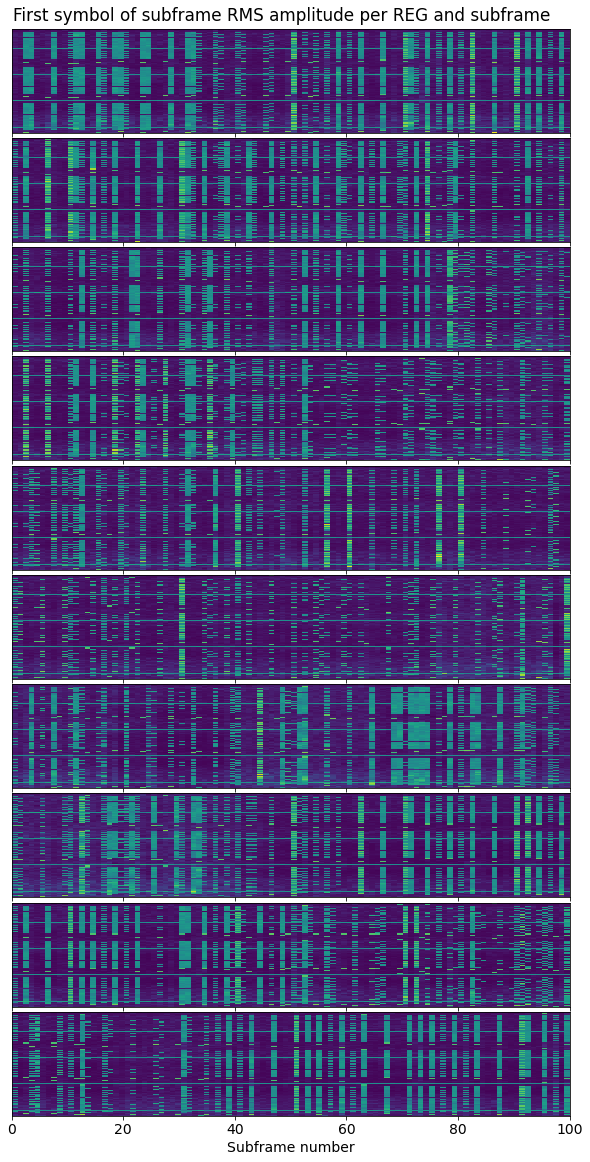

In [38]:
reg_rms = np.sqrt(np.average(np.abs(reg_symbols.reshape(-1, 2 * NRB, 4)**2), axis=-1))

fig, axs = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=True)
for j, ax in enumerate(axs):
    a = reg_rms[100*j:100*(j+1)].T[::-1]
    ax.imshow(a, vmin=0, vmax=2, aspect='auto', interpolation='none',
              extent=[0, a.shape[0], 0, 2*NRB])
    ax.set_xlim((0, 100))
    ax.set_yticks([])
axs[-1].set_xlabel('Subframe number');
fig.subplots_adjust(hspace=0.05)
plt.suptitle('First symbol of subframe RMS amplitude per REG and subframe', y=0.895);

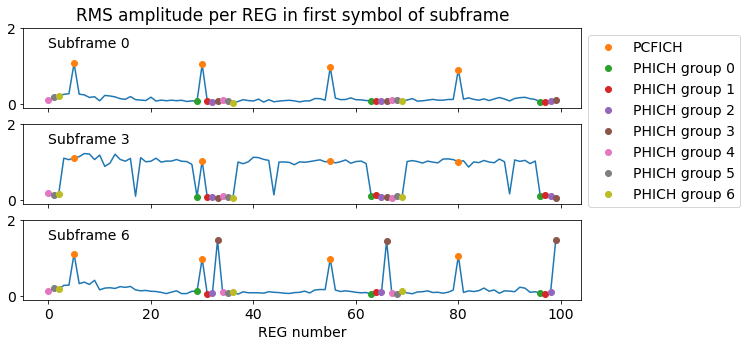

In [39]:
sfidxs = [0, 3, 6]
fig, axs = plt.subplots(len(sfidxs), 1, sharex=True, sharey=True)
for j, sfidx in enumerate(sfidxs):
    axs[j].plot(reg_rms[sfidx]);
    axs[j].plot(pcfich_regs, reg_rms[sfidx][pcfich_regs], 'o',
                label='PCFICH')
    for k, phich_r in enumerate(phich_regs):
        axs[j].plot(phich_r, reg_rms[sfidx][phich_r], 'o',
                    label=f'PHICH group {k}')
    axs[j].set_ylim((-0.1, 2))
    axs[j].text(0, 1.5, f'Subframe {sfidx}')
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[-1].set_xlabel('REG number')
plt.suptitle('RMS amplitude per REG in first symbol of subframe', y=0.94);

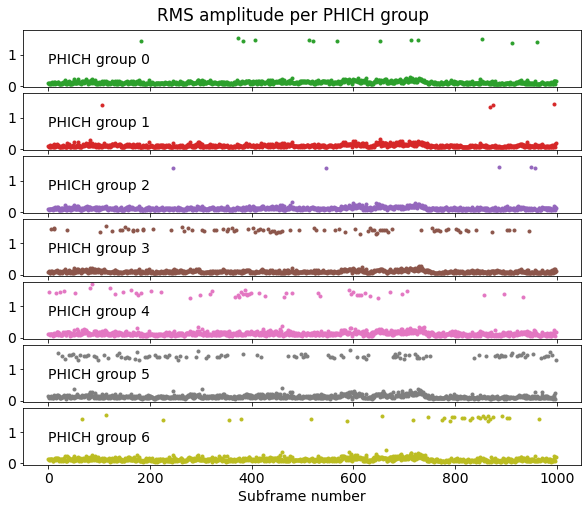

In [40]:
phich_rms = np.sqrt(np.average(reg_rms[:, phich_regs]**2, axis=-1))
fig, axs = plt.subplots(n_phich_groups, 1, sharex=True, sharey=True, figsize=(10, 8))
for j in range(n_phich_groups):
    axs[j].plot(phich_rms[:, j], '.', color=f'C{2+j}')
    axs[j].text(0, 0.7, f'PHICH group {j}')
fig.subplots_adjust(hspace=0.1)
axs[-1].set_xlabel('Subframe number')
plt.suptitle('RMS amplitude per PHICH group', y=0.92);

In [41]:
phich_active = phich_rms >= 0.7
np.sum(phich_active, axis=0) # number of PHICH transmissions per group

array([ 13,   4,   5,  87,  52, 114,  31])

In [42]:
W = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1],
              [1, 1, -1, -1],
              [1, -1, -1, 1]]).T

phich_despread = np.empty((reg_rms.shape[0], n_phich_groups,  4), 'complex')
for sfidx, symidx in enumerate(reg_nsymbols):
    ns = (symidx // 7 + ns0) % 20
    scramble = c_seq((ns//2 + 1) * (2 * pci + 1) * 2**9 + pci, 12)
    scramble = 1 - 2 * scramble.astype('float')
    
    z = reg_symbols[sfidx].reshape(-1, 4)[phich_regs]
    z = (z.reshape(-1, 12) * scramble).reshape(-1, 3, 4)
    w = 0.25 * np.einsum('ij,kli->klj', W, z)
    phich_despread[sfidx] = np.average(w, axis=1)

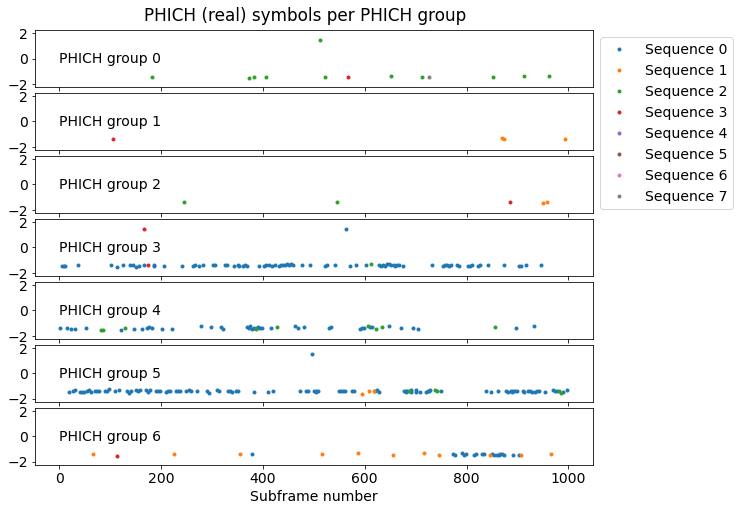

In [43]:
metric = np.real(phich_despread * np.exp(-1j*np.pi/4))
metric_imag = np.imag(phich_despread * np.exp(-1j*np.pi/4))
metric[np.abs(metric) < 0.5] = np.nan
metric_imag[np.abs(metric_imag) < 0.5] = np.nan
fig, axs = plt.subplots(n_phich_groups, 1, sharex=True, sharey=True, figsize=(10, 8))
for j in range(n_phich_groups):
    axs[j].plot(metric[:, j], '.')
    axs[j].plot(metric_imag[:, j], '.')
    axs[j].text(0, 0, f'PHICH group {j}',
                verticalalignment='center')
    axs[j].set_ylim((-2.25, 2.25))
fig.subplots_adjust(hspace=0.1)
axs[-1].set_xlabel('Subframe number')
axs[0].legend([f'Sequence {j}' for j in range(8)],
              bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle('PHICH (real) symbols per PHICH group', y=0.92);

In [44]:
np.sum(~np.isnan(metric) & (metric < 0), axis=0)

array([[  0,   0,  10,   1],
       [  0,   3,   0,   1],
       [  0,   2,   2,   1],
       [ 83,   0,   1,   1],
       [ 43,   0,   9,   0],
       [105,   3,   5,   0],
       [ 19,  11,   0,   1]])

In [45]:
np.sum(~np.isnan(metric) & (metric > 0), axis=0)

array([[0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0]])

In [46]:
np.sum(~np.isnan(metric_imag) & (metric_imag < 0), axis=0)

array([[0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [47]:
np.sum(~np.isnan(metric_imag) & (metric_imag > 0), axis=0)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [48]:
np.where(~np.isnan(metric_imag))[0]

array([727])

In [49]:
# Positions where two sequence numbers are used in the same group
np.where(np.sum((~np.isnan(metric)).astype('int')
                + (~np.isnan(metric_imag)).astype('int'), axis=-1)  > 1)

(array([], dtype=int64), array([], dtype=int64))

In [50]:
# Subframes where two groups are used at the same time
coincident_groups = np.where(np.sum((~np.isnan(metric)).astype('int')
                + (~np.isnan(metric_imag)).astype('int'), axis=(-1, -2))  > 1)[0]
coincident_groups

array([114, 182, 373, 378, 383, 407, 628, 652, 869, 874, 907, 912])

In [51]:
np.sum(~np.isnan(metric[coincident_groups]), axis=(-1, -2))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

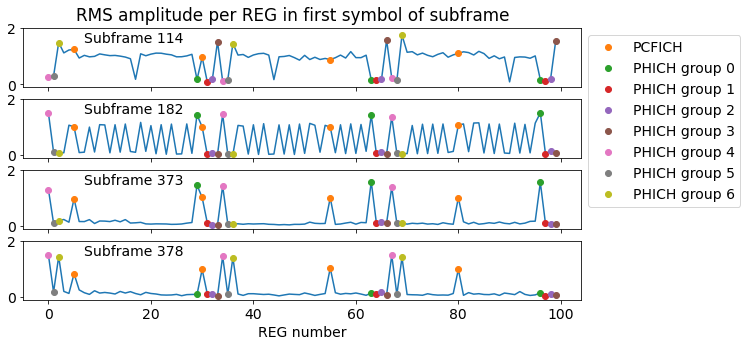

In [52]:
sfidxs = [114, 182, 373, 378]
fig, axs = plt.subplots(len(sfidxs), 1, sharex=True, sharey=True)
for j, sfidx in enumerate(sfidxs):
    axs[j].plot(reg_rms[sfidx]);
    axs[j].plot(pcfich_regs, reg_rms[sfidx][pcfich_regs], 'o',
                label='PCFICH')
    for k, phich_r in enumerate(phich_regs):
        axs[j].plot(phich_r, reg_rms[sfidx][phich_r], 'o',
                    label=f'PHICH group {k}')
    axs[j].set_ylim((-0.1, 2))
    axs[j].text(7, 1.5, f'Subframe {sfidx}')
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[-1].set_xlabel('REG number')
plt.suptitle('RMS amplitude per REG in first symbol of subframe', y=0.94);

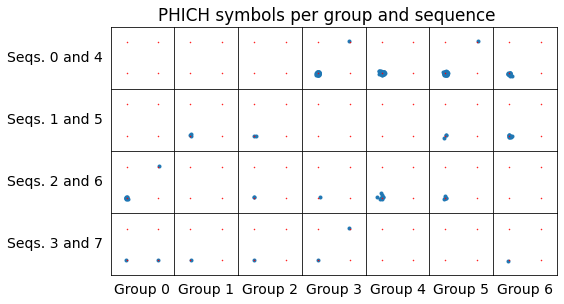

In [53]:
fig, axs = plt.subplots(4, n_phich_groups, figsize=(8, 8*4/n_phich_groups),
                        facecolor='w', sharex=True, sharey=True)
for j in range(4):
    for k in range(n_phich_groups):
        ax = axs[j, k]
        z = phich_despread[:, k, j].copy()
        z[np.abs(z) < 0.5] = np.nan
        ax.plot(z.real, z.imag, '.')
        ax.plot(np.array([1, 1, -1, -1]),
                np.array([1, -1, 1, -1]), '.',
                color='red', markersize=1)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
for j in range(4):
    axs[j, 0].set_ylabel(f'Seqs. {j} and {j+4}', rotation=0,
                         horizontalalignment='right', verticalalignment='center')
for j in range(n_phich_groups):
    axs[-1, j].set_xlabel(f'Group {j}')
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PHICH symbols per group and sequence', y=0.94);

## PBCH decoding

In [54]:
# Organize PBCH transmissions by subframe/radio frame. Each subframe carriers 240 QPSK symbols.
pbch_sf = np.array([np.concatenate(pbch[j:j+4]) for j in range(0, len(pbch), 4)])
pbch_sf.shape

(100, 240)

In [55]:
# Make a sliding window of 4 consecutive radio frames. Every 4 windows we will be correctly
# aligned to the 40 ms transmission interval for the PBCH.
pbch_windows = np.array([pbch_sf[j:j+4].ravel() for j in range(0, pbch_sf.shape[0] - 3)])
pbch_windows.shape

(97, 960)

In [56]:
# Soft symbol descrambling of the 1920 bits of each MIB sliding window
pbch_softbits = -np.sqrt(2)*np.stack((pbch_windows.real, pbch_windows.imag), axis=-1).reshape(-1, 1920)
scramble = c_seq(pci, 1920)
pbch_descrambled = pbch_softbits * (1 - 2*scramble.astype('float'))

In [57]:
def block_interleaver(x):
    NC = 32
    NR = int(np.ceil(len(x) / NC))
    x = [None] * (NC * NR - len(x)) + x
    # If x has no None's (which happens when 32 divides len(x)), then
    # the transformation to np.array will break tuples as another dimension
    # of the array. We add and remove a None entry just to prevent this.
    x = np.array(x + [None], dtype='object')[:-1].reshape(NR, NC)
    column_permuation = np.array([
        1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31,
        0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30,
    ])
    return x[:, column_permuation].T.ravel()

# Calculations for input->output mapping of the rate matching block
# D - number of input bits
# E - number of output bits
def rate_matching(D, E):
    rate_matching_input_idx = [[(j, k) for k in range(D)] for j in range(3)]
    buffer = np.concatenate([block_interleaver(x) for x in rate_matching_input_idx])
    rate_matching_output_idx = []
    k = 0
    for j in range(E):
        while True:
            element = buffer[k % len(buffer)]
            k += 1
            if element is not None:
                rate_matching_output_idx.append(element)
                break
    return rate_matching_input_idx, rate_matching_output_idx

# Collect soft symbols according to rate matching (soft combining)
def rate_matching_collect(symbols, D):
    rate_matching_input_idx, rate_matching_output_idx = rate_matching(D, symbols.size)
    collect = {b: [] for a in rate_matching_input_idx for b in a}
    for j, bit in enumerate(symbols):
        collect[rate_matching_output_idx[j]].append(bit)
    return collect

def codewords_rate_matching(symbols, D):
    collect = rate_matching_collect(symbols, D)
    rate_matching_input_idx, _ = rate_matching(D, symbols.size)
    codewords = np.array([[np.average(collect[idx]) for idx in r]
                          for r in rate_matching_input_idx])
    return codewords

In [58]:
rate_matching_collected = [rate_matching_collect(a, 24 + 16) for a in pbch_descrambled]

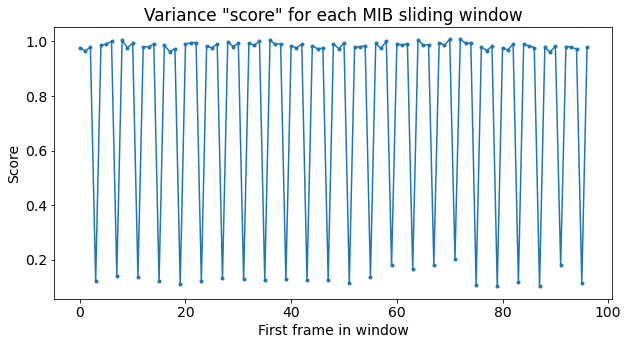

In [59]:
scores = [np.sqrt(np.average([(a - np.average(a))**2 for a in r.values()]))
          for r in rate_matching_collected]
plt.plot(scores, '.-')
plt.title('Variance "score" for each MIB sliding window')
plt.ylabel('Score')
plt.xlabel('First frame in window');

In [60]:
window_offset = 3
pbch_codewords = np.array([codewords_rate_matching(a, 24 + 16)
                           for a in pbch_descrambled[window_offset::4]])

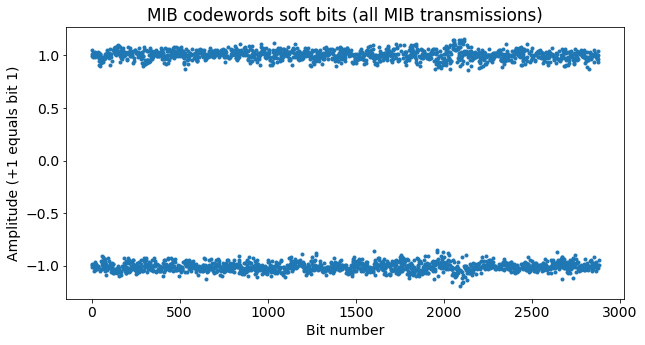

In [61]:
plt.plot(pbch_codewords.ravel(), '.')
plt.title('MIB codewords soft bits (all MIB transmissions)')
plt.xlabel('Bit number')
plt.ylabel('Amplitude (+1 equals bit 1)');

In [62]:
# Viterbi algorithm
def viterbi(y, s0=0):
    nu = 6
    # States are encoded a nu-bit numbers, where the new bits are feed into the MSB
    M = np.full(2**nu, np.infty)
    M[s0] = 0
    paths = [[] for _ in range(2**nu)]
    for t in range(y.shape[1]):
        yt = y[:, t]
        M_prev = M
        paths_prev = paths.copy()
        M = np.full(2**nu, np.infty)
        for r in range(2**nu):
            for bit in [0, 1]:
                s = (r >> 1) | (bit << (nu-1))
                d0 = (bit ^ r ^ (r >> 1) ^ (r >> 3) ^ (r >> 4)) & 1
                d1 = (bit ^ r ^ (r >> 3) ^ (r >> 4) ^ (r >> 5)) & 1
                d2 = (bit ^ r ^ (r >> 2) ^ (r >> 4) ^ (r >> 5)) & 1
                d0 = 2*d0 - 1
                d1 = 2*d1 - 1
                d2 = 2*d2 - 1
                Brs = -(d0 * yt[0] + d1 * yt[1] + d2 * yt[2])
                new = M_prev[r] + Brs
                if new < M[s]:
                    M[s] = new
                    paths[s] = paths_prev[r] + [bit]
    return M[s0], paths[s0]

def viterbi_tailbiting(y):
    viterbi_out = [viterbi(y, s0=s0) for s0 in range(2**6)]
    viterbi_M = [x[0] for x in viterbi_out]
    s0 = np.argmin(viterbi_M)
    return viterbi_out[s0][1]

In [63]:
def convencoder(u):
    s = u[-6] | (u[-5] << 1) | (u[-4] << 2) | (u[-3] << 3) | (u[-2] << 4) | (u[-1] << 5)
    d0 = []
    d1 = []
    d2 = []
    for b in u:
        d0.append((b ^ s ^ (s >> 1) ^ (s >> 3) ^ (s >> 4)) & 1)
        d1.append((b ^ s ^ (s >> 3) ^ (s >> 4) ^ (s >> 5)) & 1)
        d2.append((b ^ s ^ (s >> 2) ^ (s >> 4) ^ (s >> 5)) & 1)
        s = (s >> 1) | (b << 5)
    return [d0, d1, d2]

In [64]:
# Check that the viterbi decoder is working. We re-encode the decode of the
# first PBCH codeword.

codeword = pbch_codewords[0]
decoded = viterbi_tailbiting(codeword)
assert np.all(codeword * (2 * np.array(convencoder(decoded)) - 1) > 0)

In [65]:
pbch_decode = np.array([viterbi_tailbiting(c) for c in pbch_codewords])

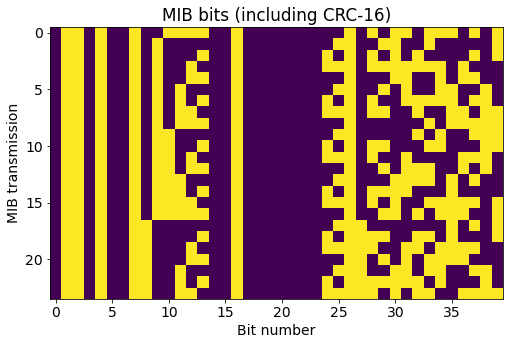

In [66]:
plt.imshow(pbch_decode)
plt.ylabel('MIB transmission')
plt.xlabel('Bit number')
plt.title('MIB bits (including CRC-16)');

In [67]:
crc_table = [0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50a5, 0x60c6, 0x70e7,
    0x8108, 0x9129, 0xa14a, 0xb16b, 0xc18c, 0xd1ad, 0xe1ce, 0xf1ef,
    0x1231, 0x0210, 0x3273, 0x2252, 0x52b5, 0x4294, 0x72f7, 0x62d6,
    0x9339, 0x8318, 0xb37b, 0xa35a, 0xd3bd, 0xc39c, 0xf3ff, 0xe3de,
    0x2462, 0x3443, 0x0420, 0x1401, 0x64e6, 0x74c7, 0x44a4, 0x5485,
    0xa56a, 0xb54b, 0x8528, 0x9509, 0xe5ee, 0xf5cf, 0xc5ac, 0xd58d,
    0x3653, 0x2672, 0x1611, 0x0630, 0x76d7, 0x66f6, 0x5695, 0x46b4,
    0xb75b, 0xa77a, 0x9719, 0x8738, 0xf7df, 0xe7fe, 0xd79d, 0xc7bc,
    0x48c4, 0x58e5, 0x6886, 0x78a7, 0x0840, 0x1861, 0x2802, 0x3823,
    0xc9cc, 0xd9ed, 0xe98e, 0xf9af, 0x8948, 0x9969, 0xa90a, 0xb92b,
    0x5af5, 0x4ad4, 0x7ab7, 0x6a96, 0x1a71, 0x0a50, 0x3a33, 0x2a12,
    0xdbfd, 0xcbdc, 0xfbbf, 0xeb9e, 0x9b79, 0x8b58, 0xbb3b, 0xab1a,
    0x6ca6, 0x7c87, 0x4ce4, 0x5cc5, 0x2c22, 0x3c03, 0x0c60, 0x1c41,
    0xedae, 0xfd8f, 0xcdec, 0xddcd, 0xad2a, 0xbd0b, 0x8d68, 0x9d49,
    0x7e97, 0x6eb6, 0x5ed5, 0x4ef4, 0x3e13, 0x2e32, 0x1e51, 0x0e70,
    0xff9f, 0xefbe, 0xdfdd, 0xcffc, 0xbf1b, 0xaf3a, 0x9f59, 0x8f78,
    0x9188, 0x81a9, 0xb1ca, 0xa1eb, 0xd10c, 0xc12d, 0xf14e, 0xe16f,
    0x1080, 0x00a1, 0x30c2, 0x20e3, 0x5004, 0x4025, 0x7046, 0x6067,
    0x83b9, 0x9398, 0xa3fb, 0xb3da, 0xc33d, 0xd31c, 0xe37f, 0xf35e,
    0x02b1, 0x1290, 0x22f3, 0x32d2, 0x4235, 0x5214, 0x6277, 0x7256,
    0xb5ea, 0xa5cb, 0x95a8, 0x8589, 0xf56e, 0xe54f, 0xd52c, 0xc50d,
    0x34e2, 0x24c3, 0x14a0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405,
    0xa7db, 0xb7fa, 0x8799, 0x97b8, 0xe75f, 0xf77e, 0xc71d, 0xd73c,
    0x26d3, 0x36f2, 0x0691, 0x16b0, 0x6657, 0x7676, 0x4615, 0x5634,
    0xd94c, 0xc96d, 0xf90e, 0xe92f, 0x99c8, 0x89e9, 0xb98a, 0xa9ab,
    0x5844, 0x4865, 0x7806, 0x6827, 0x18c0, 0x08e1, 0x3882, 0x28a3,
    0xcb7d, 0xdb5c, 0xeb3f, 0xfb1e, 0x8bf9, 0x9bd8, 0xabbb, 0xbb9a,
    0x4a75, 0x5a54, 0x6a37, 0x7a16, 0x0af1, 0x1ad0, 0x2ab3, 0x3a92,
    0xfd2e, 0xed0f, 0xdd6c, 0xcd4d, 0xbdaa, 0xad8b, 0x9de8, 0x8dc9,
    0x7c26, 0x6c07, 0x5c64, 0x4c45, 0x3ca2, 0x2c83, 0x1ce0, 0x0cc1,
    0xef1f, 0xff3e, 0xcf5d, 0xdf7c, 0xaf9b, 0xbfba, 0x8fd9, 0x9ff8,
    0x6e17, 0x7e36, 0x4e55, 0x5e74, 0x2e93, 0x3eb2, 0x0ed1, 0x1ef0]

def crc16_ccitt_zero(data):
    crc = 0
    for d in data:
        tbl_idx = ((crc >> 8) ^ d) & 0xff
        crc = (crc_table[tbl_idx] ^ (crc << 8)) & 0xffff
    return crc & 0xffff

In [68]:
mask = np.array([0, 0, 0, 0xff, 0xff])  # CRC mask for 2 antenna ports
crc_ok = [crc16_ccitt_zero(np.packbits(dec) ^ mask) == 0 for dec in pbch_decode]
np.all(crc_ok)

True

In [69]:
with tempfile.NamedTemporaryFile(mode='w+') as asnfile:
    asnfile.write("""
LTE DEFINITIONS ::= BEGIN

MasterInformationBlock ::= SEQUENCE {
dl-Bandwidth ENUMERATED {n6, n15, n25, n50, n75, n100},
phich-Config PHICH-Config,
systemFrameNumber BIT STRING (SIZE (8)),
schedulingInfoSIB1-BR-r13 INTEGER (0..31),
systemInfoUnchanged-BR-r15 BOOLEAN,
spare BIT STRING (SIZE (4))
}

PHICH-Config ::= SEQUENCE {
phich-Duration ENUMERATED {normal, extended},
phich-Resource ENUMERATED {oneSixth, half, one, two}
}

END
""")
    asnfile.flush()
    asn1 = asn1tools.compile_files(asnfile.name, 'per')

In [70]:
pbch_data = [asn1.decode('MasterInformationBlock', bytes(np.packbits(dec[:24])))
             for dec in pbch_decode]

In [71]:
sfn = np.array([list(d['systemFrameNumber'][0])[0] for d in pbch_data])
sfn

array([ 79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102])

In [72]:
pbch_data[0]

{'dl-Bandwidth': 'n50',
 'phich-Config': {'phich-Duration': 'normal', 'phich-Resource': 'one'},
 'systemFrameNumber': (b'O', 8),
 'schedulingInfoSIB1-BR-r13': 4,
 'systemInfoUnchanged-BR-r15': False,
 'spare': (b'\x00', 4)}

## PDCCH

PDCCH REG configuration for CFI = 1.

In [73]:
pdcch_regs = np.array([j for j in range(2*NRB)
                       if j not in np.concatenate((phich_regs.ravel(), pcfich_regs))])
pdcch_regs

array([ 3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95])

In [74]:
pdcch_regs_shifted = np.roll(pdcch_regs, pci)
pdcch_regs_shifted

array([91, 92, 93, 94, 95,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58,
       59, 60, 61, 62, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90])

In [75]:
pdcch_reg_interleaving = [a for a in block_interleaver([a for a in range(pdcch_regs.size)])
     if a is not None]
pdcch_reg_interleaving_inv = np.array(
    [pdcch_reg_interleaving.index(j) for j in range(pdcch_regs.size)])
pdcch_reg_interleaving_inv

array([11, 67, 30, 44,  6, 62, 25, 53, 16, 72, 35, 38,  0, 56, 19, 47,  9,
       65, 28, 42,  4, 60, 23, 51, 14, 70, 33, 40,  2, 58, 21, 49, 12, 68,
       31, 45,  7, 63, 26, 54, 17, 73, 36, 39,  1, 57, 20, 48, 10, 66, 29,
       43,  5, 61, 24, 52, 15, 71, 34, 41,  3, 59, 22, 50, 13, 69, 32, 46,
        8, 64, 27, 55, 18, 74, 37])

In [76]:
pdcch_sorted = reg_symbols.reshape(-1, 2*NRB, 4)[:, pdcch_regs_shifted[pdcch_reg_interleaving_inv]]

PDCCH REG configuration for CFI = 2.

In [77]:
# First subcarrier for each of the PDCCH regs of the 1st symbol
regs_1st_symbol_subc = pdcch_regs * 6 + (1 if pci % 3 == 0 else 0)
regs_1st_symbol_subc

array([ 18,  24,  36,  42,  48,  54,  60,  66,  72,  78,  84,  90,  96,
       102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 222,
       228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300,
       306, 312, 318, 324, 336, 342, 348, 354, 360, 366, 372, 420, 426,
       432, 438, 444, 450, 456, 462, 468, 474, 486, 492, 498, 504, 510,
       516, 522, 528, 534, 540, 546, 552, 558, 564, 570])

In [78]:
# First subcarrier for each of the PDCCH regs of the 2nd symbol
# (only valid for 2 CRS ports)
regs_2nd_symbol_subc = np.arange(NRB * 3) * 4
regs_2nd_symbol_subc

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
       156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
       208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
       260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
       312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360,
       364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412,
       416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464,
       468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516,
       520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568,
       572, 576, 580, 584, 588, 592, 596])

In [79]:
# (symbol, REG index) pairs ordered by PDCCH REG number
cfi2_regs = (
    [(0, j, k) for j, k in zip(pdcch_regs, regs_1st_symbol_subc)]
    + [(1, j, k) for j, k in enumerate(regs_2nd_symbol_subc)])
cfi2_regs = [a[:2] for a in sorted(cfi2_regs, key=lambda x: (x[2], x[0]))]
len(cfi2_regs)

225

In [80]:
cfi2_regs_shifted = np.roll(cfi2_regs, pci, axis=0)
cfi2_reg_interleaving = [a for a in block_interleaver([a for a in range(len(cfi2_regs))])
     if a is not None]
cfi2_reg_interleaving_inv = np.array(
    [cfi2_reg_interleaving.index(j) for j in range(len(cfi2_regs))])
cfi2_permutation = cfi2_regs_shifted[cfi2_reg_interleaving_inv]

In [81]:
reg_symbols_sym2 = np.empty((reg_nsymbols.size, 4 * 3 * NRB), 'complex')
for j, symidx in enumerate(reg_nsymbols + 1):
    r0, r1 = channel(symidx)
    reg_symbols_sym2[j] = diversity(symbols[symidx, no_dc], r0[no_dc], r1[no_dc])

In [82]:
pdcch_sorted_cfi2 = np.empty((reg_nsymbols.size, len(cfi2_regs), 4), 'complex')
symbol0_sel = cfi2_permutation[:, 0] == 0
pdcch_sorted_cfi2[:, symbol0_sel] = reg_symbols.reshape(-1, 2*NRB, 4)[:, cfi2_permutation[symbol0_sel, 1]]
pdcch_sorted_cfi2[:, ~symbol0_sel] = reg_symbols_sym2.reshape(-1, 3*NRB, 4)[:, cfi2_permutation[~symbol0_sel, 1]]

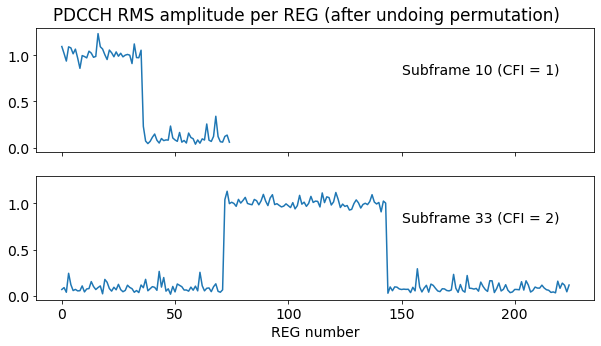

In [83]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].plot(np.sqrt(np.average(np.abs(pdcch_sorted[10])**2, axis=-1)))
axs[0].text(150, 0.8, 'Subframe 10 (CFI = 1)')
axs[1].plot(np.sqrt(np.average(np.abs(pdcch_sorted_cfi2[33])**2, axis=-1)))
axs[1].text(150, 0.8, 'Subframe 33 (CFI = 2)')
axs[1].set_xlabel('REG number')
plt.suptitle('PDCCH RMS amplitude per REG (after undoing permutation)', y=0.94);

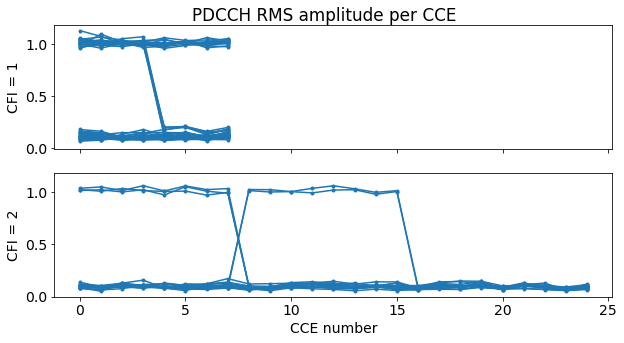

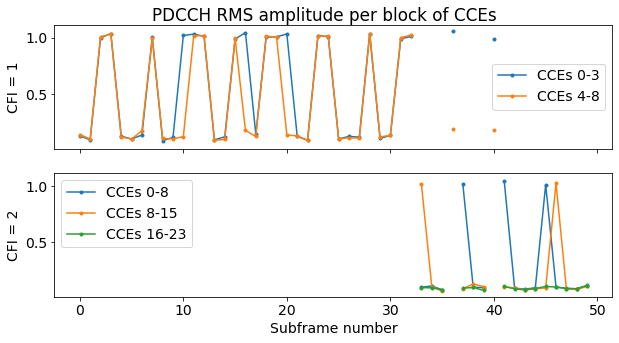

In [84]:
ncces = pdcch_sorted.shape[1] // 9
ncces_cfi2 = pdcch_sorted_cfi2.shape[1] // 9
cce_rms = np.sqrt(np.average(np.abs(
    pdcch_sorted[:, :9*ncces].reshape(-1, ncces, 36))**2,
    axis=-1))
cce_rms_cfi2 = np.sqrt(np.average(np.abs(
    pdcch_sorted_cfi2[:, :9*ncces_cfi2].reshape(-1, ncces_cfi2, 36))**2,
    axis=-1))
time_sel = slice(0, 50)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
y = cce_rms[time_sel].copy()
y[pcfich_values[time_sel] != 1] = np.nan
axs[0].plot(y.T, '.-', color='C0')
axs[0].set_ylabel('CFI = 1')
y = cce_rms_cfi2[time_sel].copy()
y[pcfich_values[time_sel] != 2] = np.nan
axs[1].plot(y.T, '.-', color='C0')
axs[1].set_xlabel('CCE number')
axs[1].set_ylabel('CFI = 2')
plt.suptitle('PDCCH RMS amplitude per CCE', y=0.93);

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
y = cce_rms[time_sel].copy()
y[pcfich_values[time_sel] != 1] = np.nan
y = np.sqrt(np.average(y.reshape(y.shape[0], -1, 4)**2, axis=-1))
axs[0].plot(y, '.-')
axs[0].legend(['CCEs 0-3', 'CCEs 4-8'])
axs[0].set_ylabel('CFI = 1')
y = cce_rms_cfi2[time_sel].copy()
y[pcfich_values[time_sel] != 2] = np.nan
y = np.sqrt(np.average(y[:, :24].reshape(y.shape[0], -1, 8)**2, axis=-1))
axs[1].plot(y, '.-')
axs[1].legend(['CCEs 0-8', 'CCEs 8-15', 'CCEs 16-23'])
axs[1].set_xlabel('Subframe number')
axs[1].set_ylabel('CFI = 2')
plt.suptitle('PDCCH RMS amplitude per block of CCEs', y=0.93);

In [85]:
pdcch_descrambled = np.empty((pdcch_sorted.shape[0], 2 * 4 * 9 * ncces))
pdcch_descrambled_cfi2 = np.empty((pdcch_sorted_cfi2.shape[0], 2 * 4 * 9 * ncces_cfi2))
for j in range(pdcch_sorted.shape[0]):
    pdcch_transmission = pdcch_sorted[j, :9*ncces].ravel()
    pdcch_transmission_cfi2 = pdcch_sorted_cfi2[j, :9*ncces_cfi2].ravel()
    symidx = reg_nsymbols[j]
    ns = (symidx // 7 + ns0) % 20
    softbits = -np.sqrt(2) * np.stack((pdcch_transmission.real, pdcch_transmission.imag), axis=-1).ravel()
    softbits_cfi2 = -np.sqrt(2) * np.stack((pdcch_transmission_cfi2.real,
                                            pdcch_transmission_cfi2.imag), axis=-1).ravel()
    scramble = c_seq((ns // 2) * 2**9 + pci, softbits_cfi2.size)
    pdcch_descrambled[j] = softbits * (1 - 2*scramble[:softbits.size].astype('float'))
    pdcch_descrambled_cfi2[j] = softbits_cfi2 * (1 - 2*scramble.astype('float'))

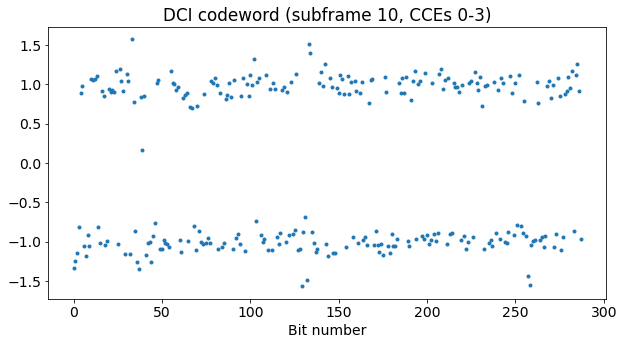

In [86]:
bits_per_cce = 2 * 4 * 9
plt.plot(pdcch_descrambled[10, :4 * bits_per_cce], '.')
plt.title('DCI codeword (subframe 10, CCEs 0-3)')
plt.xlabel('Bit number');

In [87]:
def compute_scores(symbols, max_input_bits=128):
    input_bits = np.arange(16, max_input_bits)
    scores = np.empty(input_bits.size)
    for j, nbits in enumerate(input_bits):
        collect = rate_matching_collect(symbols, nbits)
        score = np.max([np.max(a) - np.min(a) if len(a) != 0 else 0 for a in collect.values()])
        scores[j] = score
    return input_bits, scores

Text(0, 0.5, 'Score')

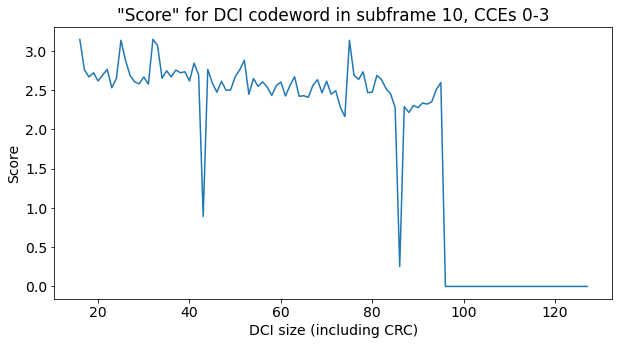

In [88]:
plt.plot(*compute_scores(pdcch_descrambled[10, :4 * bits_per_cce]))
plt.title('"Score" for DCI codeword in subframe 10, CCEs 0-3')
plt.xlabel('DCI size (including CRC)')
plt.ylabel('Score')

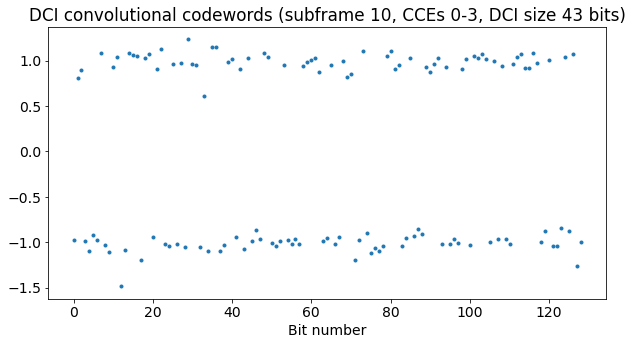

In [89]:
codewords = codewords_rate_matching(pdcch_descrambled[10, :4 * bits_per_cce], 43)

plt.plot(codewords.ravel(), '.')
plt.title('DCI convolutional codewords (subframe 10, CCEs 0-3, DCI size 43 bits)')
plt.xlabel('Bit number');

In [90]:
decoded = viterbi_tailbiting(codewords)
decoded_packed = np.packbits([0] * (8 - (len(decoded) % 8)) + decoded)
crc16_calc = crc16_ccitt_zero(decoded_packed[:-2])
crc16_recv = (decoded_packed[-2].astype('int') << 8) | decoded_packed[-1].astype('int')
crc16_mask = crc16_calc ^ crc16_recv
hex(crc16_mask)

'0xfffe'

In [91]:
bytes(np.packbits(decoded[:-16])).hex()

'86408040'

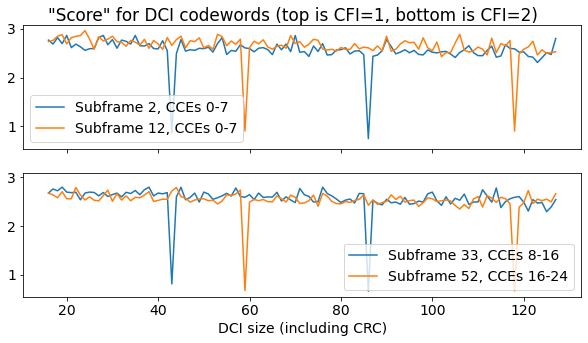

In [92]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].plot(*compute_scores(pdcch_descrambled[2, :8 * bits_per_cce]),
            label='Subframe 2, CCEs 0-7')
axs[0].plot(*compute_scores(pdcch_descrambled[12, :8 * bits_per_cce]),
            label='Subframe 12, CCEs 0-7')
axs[1].plot(*compute_scores(pdcch_descrambled_cfi2[33, 8*bits_per_cce:16*bits_per_cce]),
            label='Subframe 33, CCEs 8-16')
axs[1].plot(*compute_scores(pdcch_descrambled_cfi2[52, 16*bits_per_cce:24*bits_per_cce]),
            label='Subframe 52, CCEs 16-24')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('DCI size (including CRC)')
plt.suptitle('"Score" for DCI codewords (top is CFI=1, bottom is CFI=2)', y=0.93);

In [93]:
dci_parameters = [(2, 8, 43), (3, 8, 43), (7, 8, 43), (10, 4, 43), (11, 8, 43), (12, 8, 59),
                  (15, 8, 43), (16, 4, 43), (18, 8, 59), (19, 8, 43), (20, 4, 43),
                  (23, 8, 43), (24, 8, 43), (28, 8, 43), (31, 8, 59), (32, 8, 59),
                  (33, (8, 16), 43), (36, 4, 43), (37, 8, 43), (40, 4, 43),
                  (41, 8, 43), (45, 8, 43), (46, (8, 16), 43),
                  (50, 4, 43), (50, (4, 8), 43),
                  (52, (16, 24), 59)]
for subframe_idx, cces, dci_len in dci_parameters:
    if isinstance(cces, int):
        start_cce = 0
        end_cce = cces
    else:
        start_cce = cces[0]
        end_cce = cces[1]
    print(f'Subframe index {subframe_idx}: CFI {pcfich_values[subframe_idx]}, '
          f'CCEs {start_cce}-{end_cce-1}, {dci_len} bit DCI')
    get_symbols = pdcch_descrambled if pcfich_values[subframe_idx] == 1 else pdcch_descrambled_cfi2
    codewords = codewords_rate_matching(
        get_symbols[subframe_idx, start_cce*bits_per_cce:end_cce*bits_per_cce],
        dci_len)
    decoded = viterbi_tailbiting(codewords)
    decoded_packed = np.packbits([0] * (8 - (len(decoded) % 8)) + decoded)
    crc16_calc = crc16_ccitt_zero(decoded_packed[:-2])
    crc16_recv = (decoded_packed[-2].astype('int') << 8) | decoded_packed[-1].astype('int')
    crc16_mask = crc16_calc ^ crc16_recv
    print('CRC-16 mask', hex(crc16_mask))
    print('DCI (hex, without CRC)', bytes(np.packbits(decoded[:-16])).hex())
    print()

Subframe index 2: CFI 1, CCEs 0-7, 43 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 04c84800

Subframe index 3: CFI 1, CCEs 0-7, 43 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 03384800

Subframe index 7: CFI 1, CCEs 0-7, 43 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 04d02800

Subframe index 10: CFI 1, CCEs 0-3, 43 bit DCI
CRC-16 mask 0xfffe
DCI (hex, without CRC) 86408040

Subframe index 11: CFI 1, CCEs 0-7, 43 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 03487000

Subframe index 12: CFI 1, CCEs 0-7, 59 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 00079e080160

Subframe index 15: CFI 1, CCEs 0-7, 43 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 04d00800

Subframe index 16: CFI 1, CCEs 0-3, 43 bit DCI
CRC-16 mask 0xffff
DCI (hex, without CRC) 84b0c240

Subframe index 18: CFI 1, CCEs 0-7, 59 bit DCI
CRC-16 mask 0xced8
DCI (hex, without CRC) 7c07ce101000

Subframe index 19: CFI 1, CCEs 0-7, 43 bit DCI
CRC-16 mask 0xc33c
DCI (hex, without CRC) 01bf6880

Subfr